I. Set Up

In [2]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
import astropy.stats.bayesian_blocks as bb
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[1],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', index=1, options=('All', 'Bona'), value='Bona')

II. Data Preparation

In [4]:
# # Set ID
# set_id = set_widget.value
# # Create region filtered files 
# region_filter_fun(global_path,set_id)
# # Create eventfile table
# create_eventfilestable_fun(global_path,set_id)
# # Combine all property tables with each other
# # dfp_list =[]
# # for prop_filename in glob.iglob(f'{global_path}/{set_id}/properties-{set_id}-*.csv'):
# #    dfp = pd.read_csv(prop_filename)
# #    dfp_list.append(dfp)
# # df_properties = pd.concat(dfp_list)
# # df_properties.to_csv(f'{global_path}/{set_id}/properties-{set_id}.csv',index=False)

# # Reduce data for useful input to data representation
# df_eventfiles = pd.read_csv(f'{global_path}/{set_id}/eventfiles-{set_id}.csv')
# df_properties = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
# df_eventfiles_input, df_properties_input = data_reduction_fun(df_eventfiles, df_properties,global_path,set_id)



ValueError: No objects to concatenate

III. Load

In [3]:
from matplotlib.colors import LogNorm
from sherpa.astro import ui

# Set ID
set_id = set_widget.value

df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')

df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')

print("Number of Eventfiles: ", df_eventfiles_group.ngroups)
print("Number of Property Sets: ", df_properties_group.ngroups)


Number of Eventfiles:  82283
Number of Property Sets:  82283


In [22]:
def hist3D(df_eventfile_input, id_name, nbins_E, nbins_t, nbins_dt, plot = True, colmap = 'plasma'):
    # Copy df
    df = df_eventfile_input.copy()
    df.sort_values(by='time', inplace = True) 
    df.reset_index(drop=True, inplace = True)
    # Define histogram boundaries
    E_start = np.log10(500)
    E_end = np.log10(7000)
    t_start = 0
    t_end = 1
    dt_start = 0
    dt_end = 1
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    # Add E, t, dt columns
    df["E"] = np.log10(df["energy"])
    df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
    # df["delta_time"] = df['time'].diff().shift(-1)
    # df = df[df["delta_time"].notna()]
    # df["dt"] = (df['delta_time'] - df['delta_time'].mean()) / df['delta_time'].std() 
    # df["dt"] = (df["dt"]-min(df["dt"]))/(max(df["dt"])-min(df["dt"]))
    df["delta_time"] = df['t'].diff().shift(-1)
    df = df[df["delta_time"].notna()]
    df["dt"] = (df['delta_time']-min(df['delta_time']))/(max(df['delta_time'])-min(df['delta_time']))
    # Add Et histogram
    hist3D, edges = np.histogramdd((df["t"], df["E"], df["dt"]), range = [[t_start,t_end],[E_start, E_end], [dt_start, dt_end]],bins=(nbins_t,nbins_E, nbins_dt))
    # Create feature
    feature = hist3D
    # Plot
    if plot == True:
        fig = plt.figure(figsize=(10, 10),constrained_layout = True)
        fig.suptitle(f'ObsID: {obsid}, RegID: {regid}, N: {N_length}, T: {int(T_duration)}s')
        # Plot the E-t projection
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.imshow(hist3D.sum(axis=2).T, origin='lower', extent=[t_start,t_end, E_start, E_end],cmap=colmap,norm=LogNorm())
        ax1.set_xlabel(r'$\tau$')
        ax1.set_ylabel(r'$\epsilon$')
        ax1.set_title(r'$\epsilon$ vs $\tau$ Projection')

        # Plot the dt-t projection
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.imshow(hist3D.sum(axis=1).T, origin='lower', extent=[t_start,t_end, dt_start, dt_end],cmap=colmap,norm=LogNorm())
        ax2.set_xlabel(r'$\tau$')
        ax2.set_ylabel(r'$\delta\tau$')
        ax2.set_title(r'$\delta\tau$ vs $\tau$ Projection')

        # Plot the YZ projection
        ax3 = fig.add_subplot(2, 2, 3)
        ax3.imshow(hist3D.sum(axis=0), origin='lower', extent=[dt_start,dt_end, E_start, E_end],cmap=colmap,norm=LogNorm())
        ax3.set_xlabel(r'$\delta\tau$')
        ax3.set_ylabel(r'$\epsilon$')
        ax3.set_title(r'$\epsilon$ vs $\delta\tau$ Projection')

        # Plot 3D Histogram
        ax4 = fig.add_subplot(2, 2, 4, projection='3d')
        tt, EE, dtdt = np.meshgrid(edges[0][:-1], edges[1][:-1], edges[2][:-1], indexing='ij')
        tt = np.ravel(tt)
        EE = np.ravel(EE)
        dtdt = np.ravel(dtdt)
        h = np.ravel(hist3D)
        ax4.scatter(dtdt, tt, EE, s=250*h/max(h), alpha=0.5, edgecolors='none', c=h, cmap=colmap)
        ax4.set_xlabel(r'$\delta\tau$')
        ax4.set_ylabel(r'$\tau$')
        ax4.set_zlabel(r'$\epsilon$')
        ax4.set_title('3D Histogram')
        ax4.view_init(elev=30, azim=45)
        ax4.xaxis.set_ticks_position('bottom')
        ax4.yaxis.set_ticks_position('top')
        ax4.zaxis.set_ticks_position('bottom')
        ax4.invert_xaxis()
        plt.show()
    return feature


/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


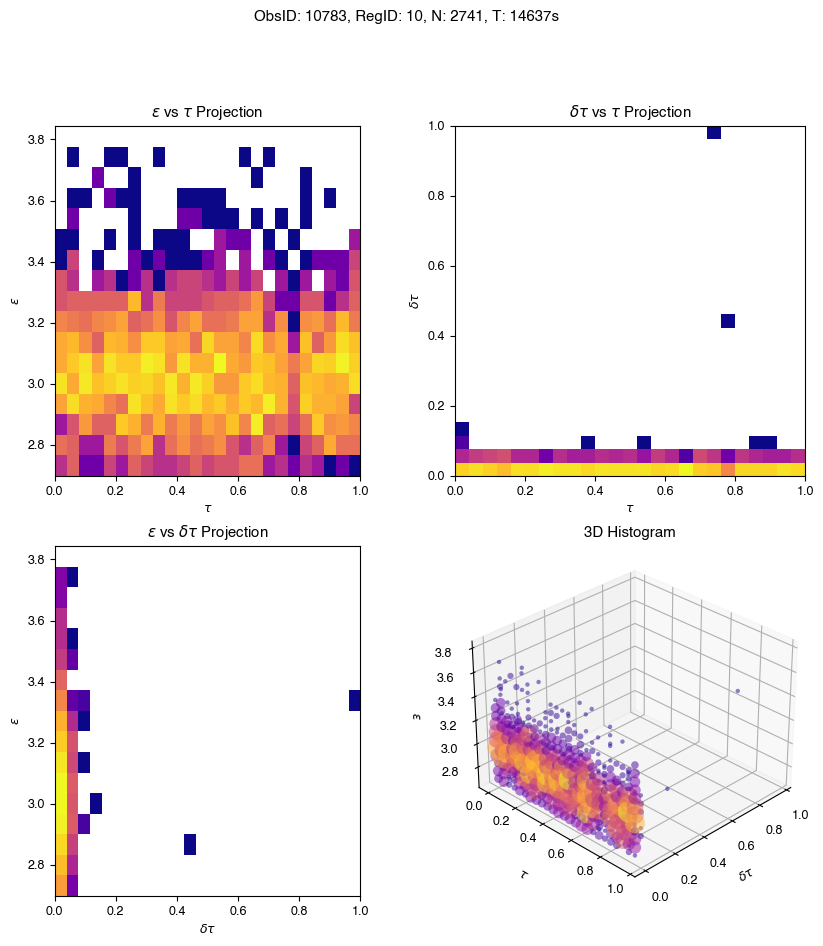

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


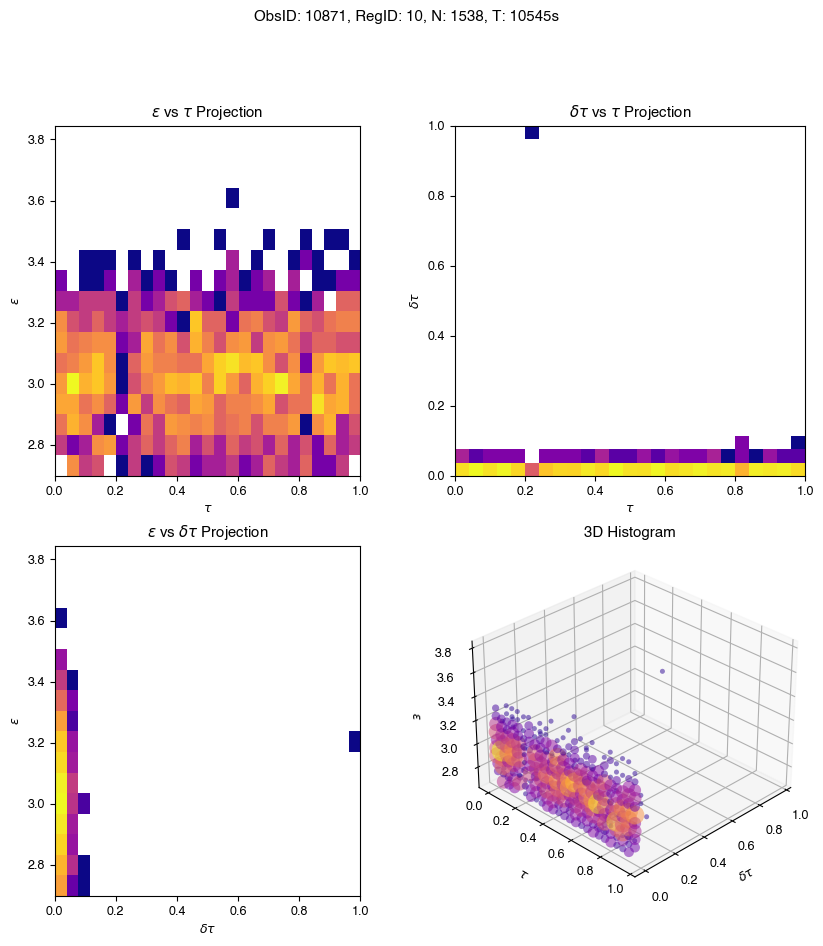

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


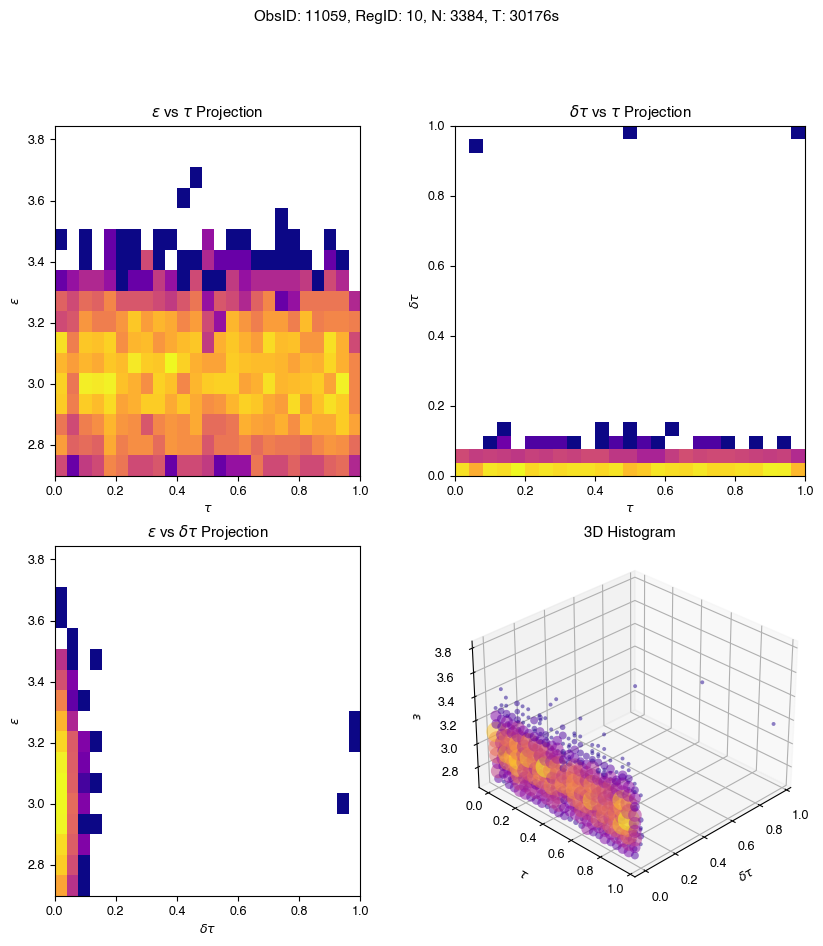

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


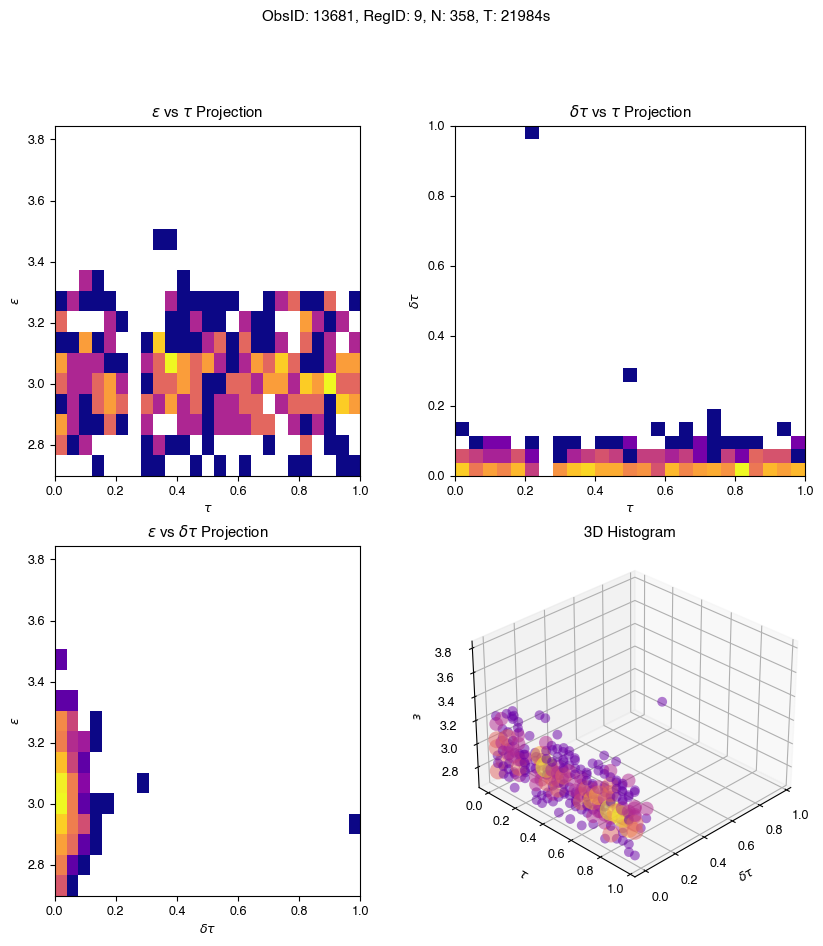

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


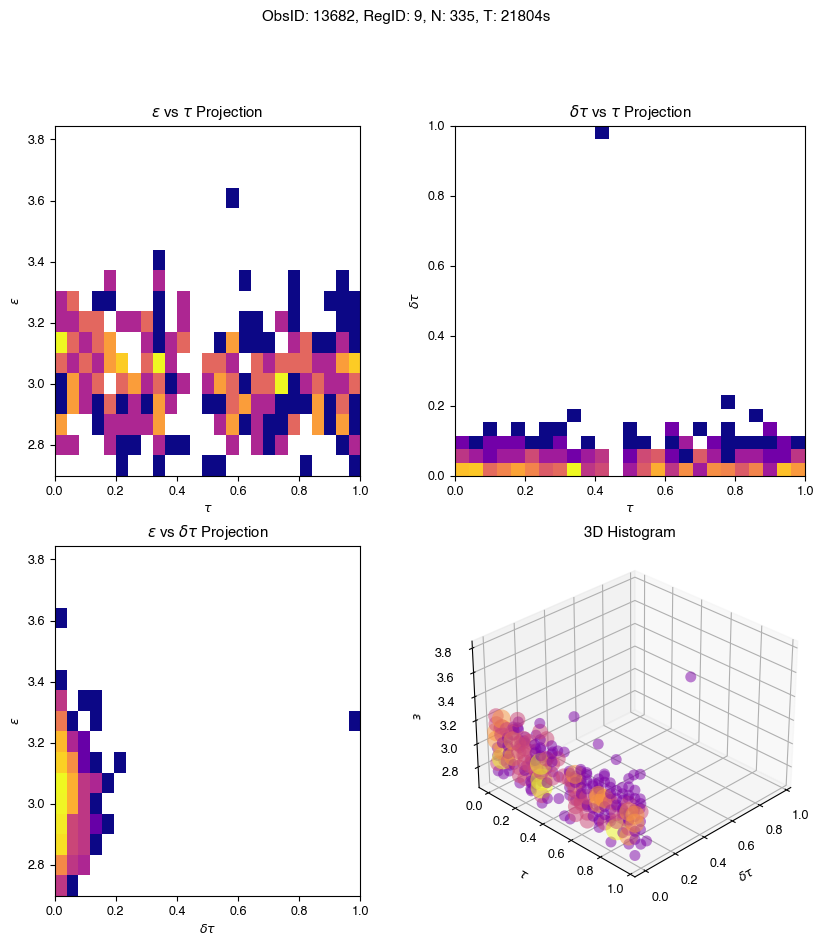

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


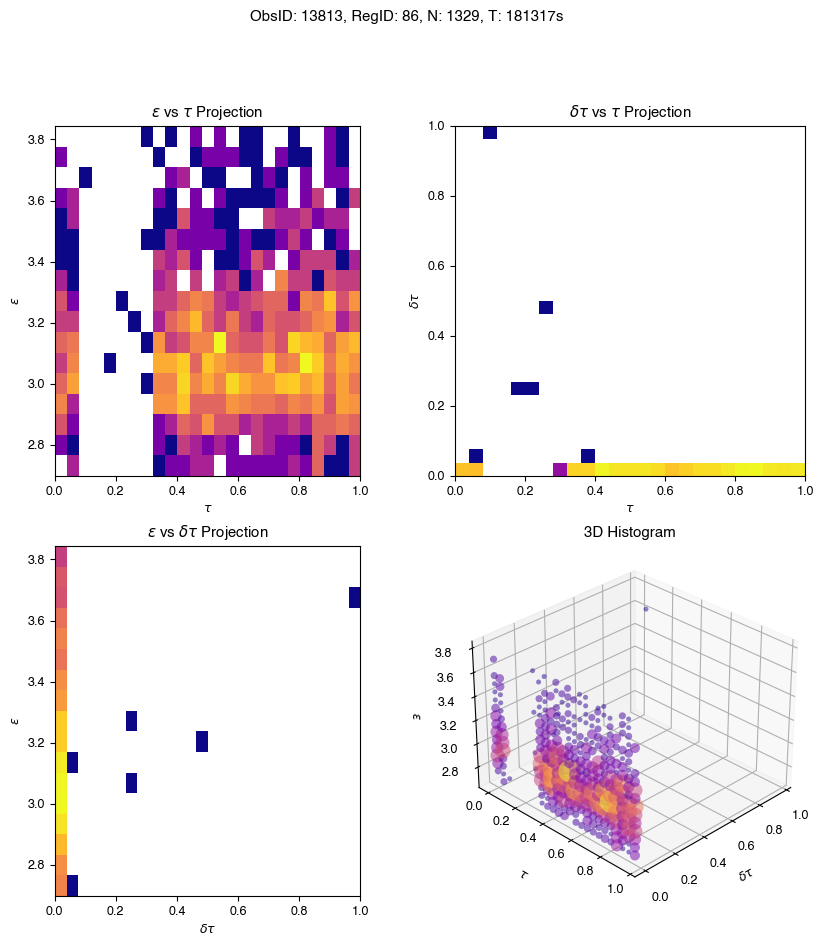

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


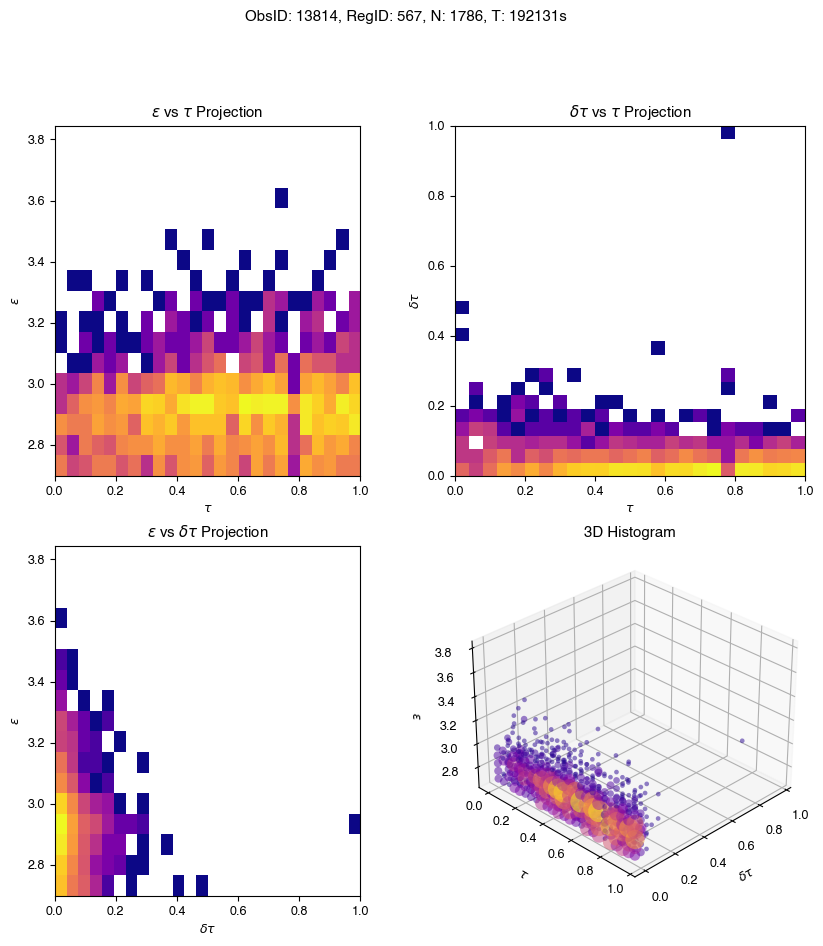

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


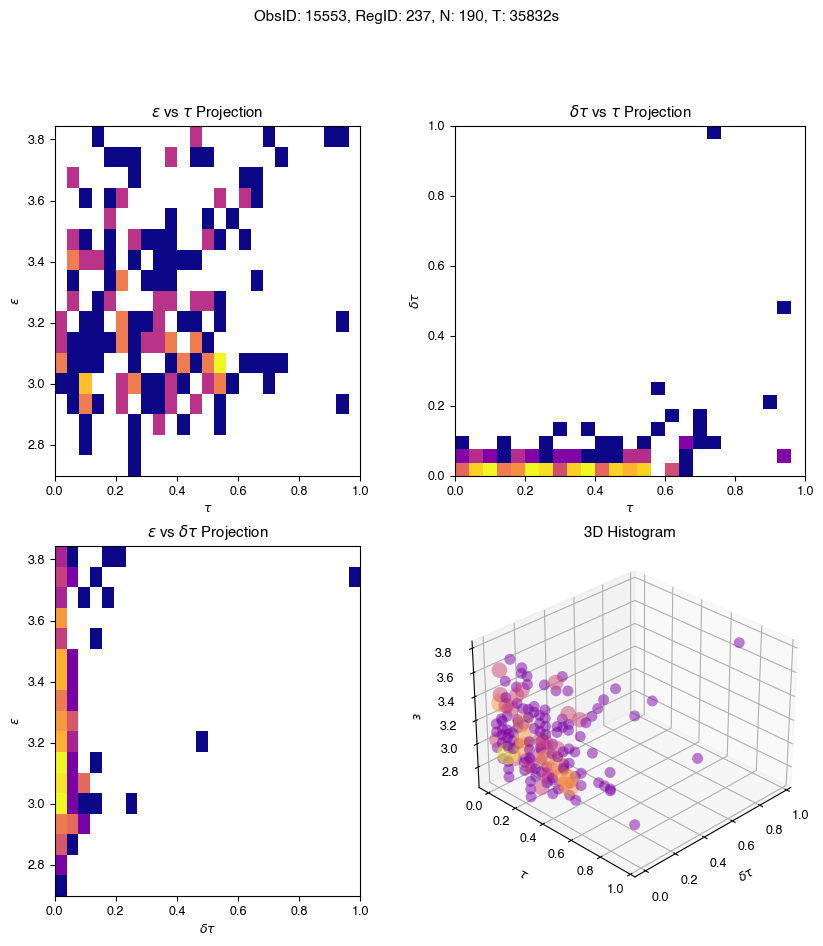

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


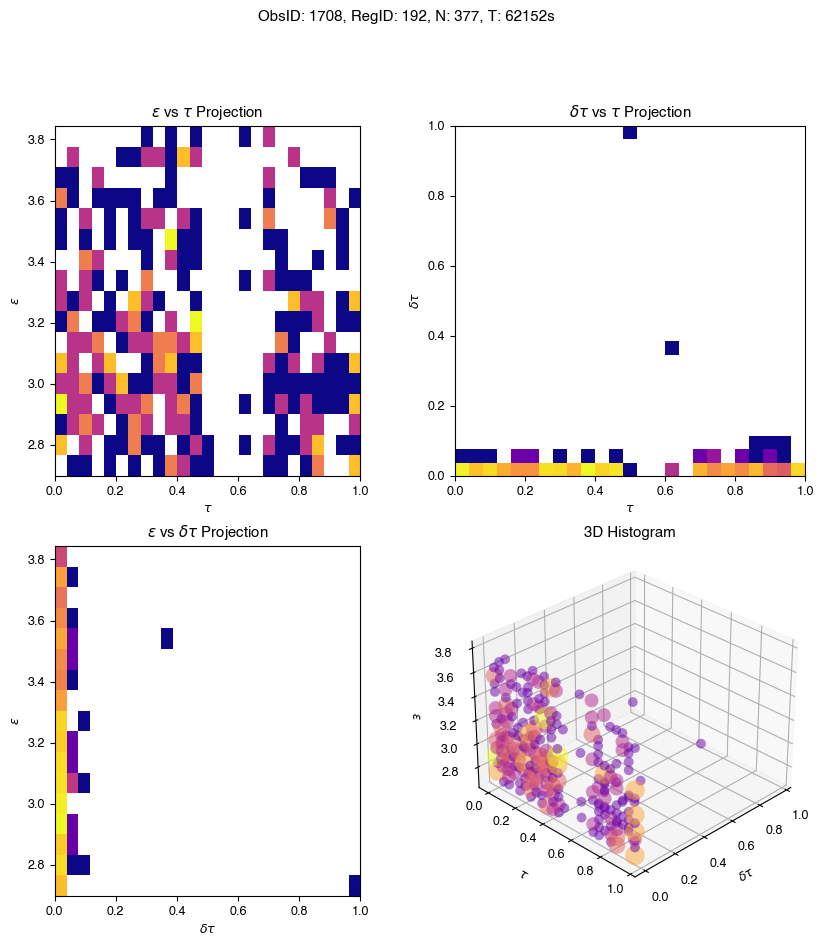

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


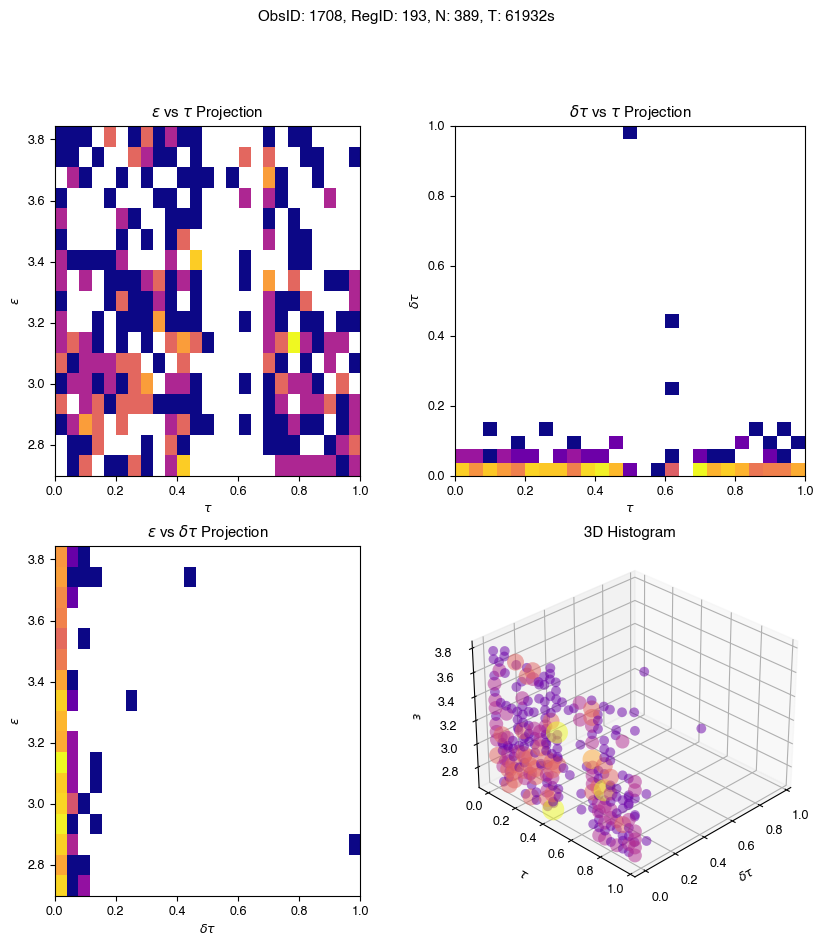

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


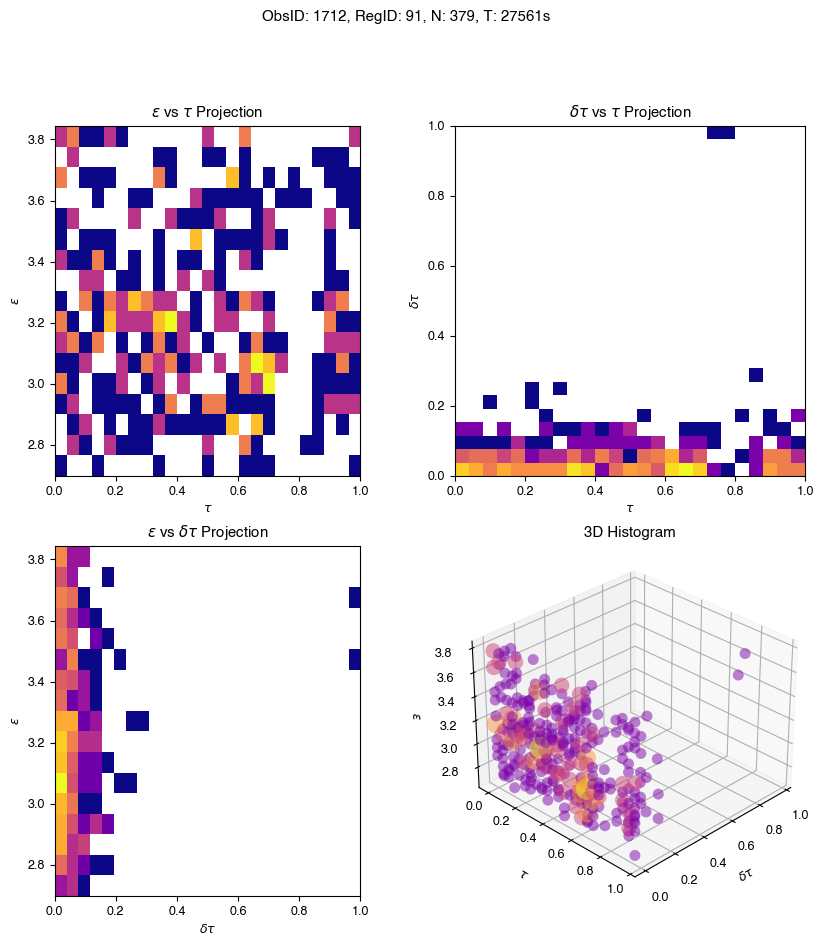

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


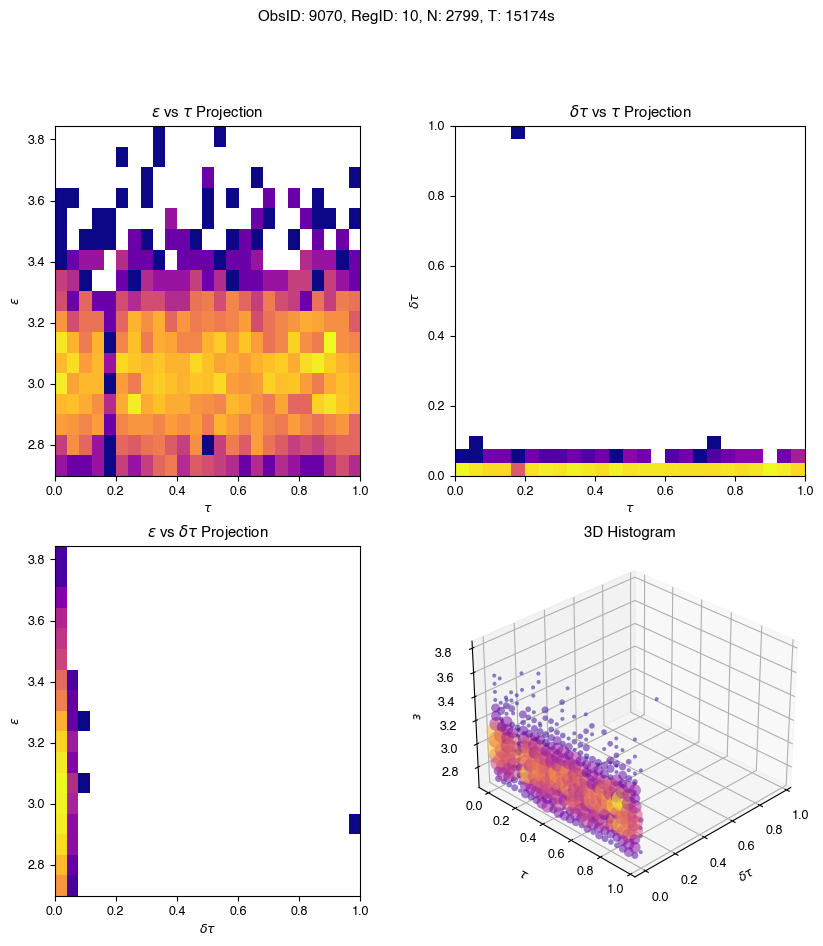

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


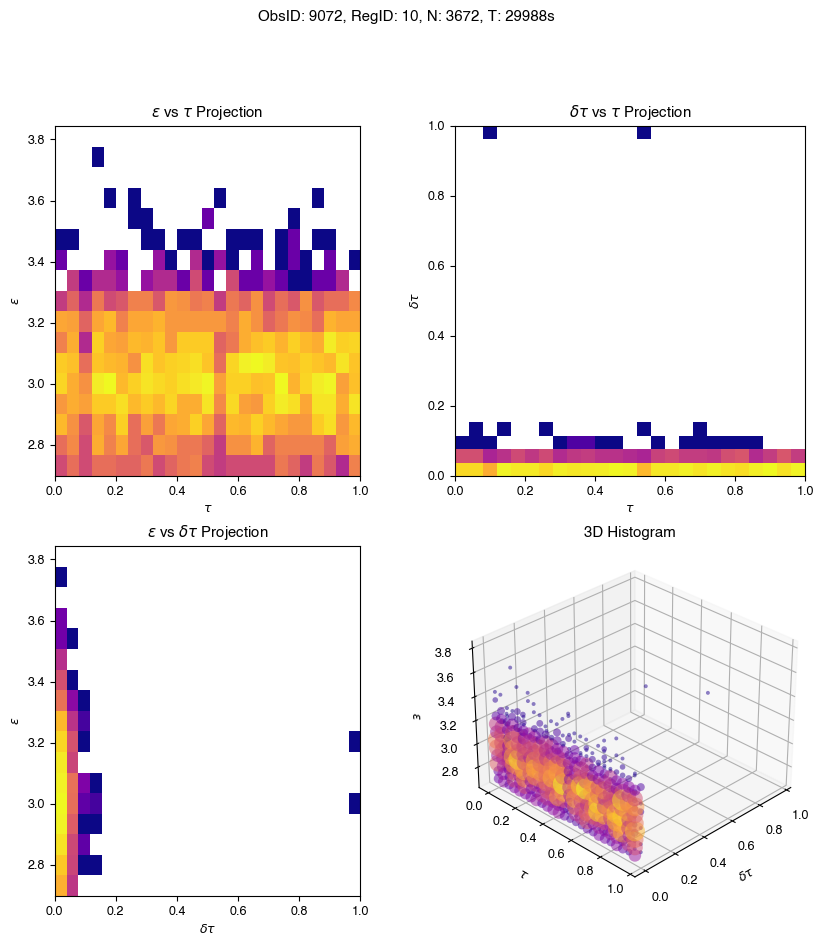

In [24]:
# Set ID
set_id = set_widget.value
# Filter for ObsRegIDs
all_ids = list(df_eventfiles_group.groups.keys())
flares = ['9109_333','9109_344','13637_1078','14368_489','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29']
dips = ['10783_10','10871_10','11059_10','9070_10','9072_10','13814_567','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86']
fd22 = ['13814_567','13828_46','11092_46', '13252_46','13673_46','2225_46','2760_46','4736_46','2207_46','16235_46','14932_46','13711_46','13722_46','14361_46'] # ['10871_10','13814_567','15267_38','11016_168','1690_2']
#Filter for source
filtered_ids = [id for id in all_ids if id.split('_')[1] == '46']
# Filter here
filter = dips #['10871_10','13814_567','14368_489','9109_333'] #flares # ['14368_489','14368_503','14431_16','14542_18']
#df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in all_ids).groupby('obsreg_id')
df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in filter).groupby('obsreg_id')
# Settings
Emin = np.log10(500)
Emax = np.log10(7000)
# E and dt binning
nbins_Eavg = 10 #19 #18
nbins_dtavg = 16  #32 #31
nbins_E75 = 11 #11 #10
nbins_dt75 = 21 #20 #18
nbins_E90 = 16 #15 #14
nbins_dt90 = 28 #27 #26
nbins_E95 = 20 #19 #18
nbins_dt95 = 33 #32 #31

nE = 17
ndt = 26
nt = 25

for id_name, dfi in df_eventfiles_group_filtered:
    dfi.sort_values(by='time', inplace = True) 
    dfi.reset_index(drop=True, inplace = True)
    #lc_plotter_fun(dfi,id_name,2000)
    #lc_plotter_fun_2(dfi,id_name,2000)
    #hist2D_Et(dfi, id_name,nE, nt,norm = 'none',plot=True)
    hist3D(dfi, id_name, nE, nt,ndt,plot=True)
   # hist3D_2(dfi, id_name, nE, nt,ndt,dtscale = 'mm', plot=True)
  


In [12]:
yoyo  = ['10871_10','13814_567','10964_283','11013_79','11016_168']
interes = ['11272_13','11275_162','13814_567']
keep_obsreg = ['11389_67','11433_80','11467_1','11480_1','11479_11','11530_42','11541_94','11574_37','11574_98','11574_102','11579_12','11579_17','11587_1','11680_3']
keep_obsreg = ['11541_94','11587_1','11680_3']
keep_obsreg = ['11721_144','11737_157','11737_57','11737_59','11744_13','11744_8']
keep_obsreg = ['11744_13']
keep_obsreg = ['11751_30','11753_69','11780_26','11781_106','11781_95','11786_6','11790_25','11790_53','11792_12']
keep_obsreg = ['11801_13','11807_38','11840_67','11841_193','11841_584']
keep_obsreg = ['11988_38','12046_146'] #interesting
keep_obsreg = ['12328_839'] #interesting
keep_obsreg = ['12390_136'] #big flare!
keep_obsreg = ['12845_2'] 
keep_obsreg = ['12975_228','12975_450','12975_816','12976_810'] 
keep_obsreg = ['12992_101','12995_101'] # !!
keep_obsreg = ['13119_278'] 
keep_obsreg = ['13202_180'] 
keep_obsreg = ['13218_36'] 
keep_obsreg = ['13246_447','13252_409','13399_25'] #?
keep_obsreg = ['13428_201','13436_140'] 
keep_obsreg = ['13451_92','13452_46'] # INTERESTING DIP? 300
keep_obsreg = ['13500_112','13610_112','13611_34'] # BIG FLARE !!
bigf = ['13637_1078','13637_2287','13637_2689'] # BIG FLARE !!!!! and OSCILLATIONS
keep_obsreg = ['13681_9','13682_9'] # hmm same region source dips
keep_obsreg = ['13706_892'] # 
keep_obsreg = ['13713_3'] # 
keep_obsreg = ['13783_1738'] # 
keep_obsreg = ['13812_251'] # hmmm x2 weird
keep_obsreg = ['13812_586'] # DIP!!!
keep_obsreg = ['13813_218'] # rise
keep_obsreg = ['13813_86'] # dipp, large time no photons
keep_obsreg = ['13814_218','13814_237']
keep_obsreg = ['13815_567','13815_586','13815_269'] # 13815 ObsID lets go
# keep_obsreg = ['13814_567','13814_586','13814_86','13814_1103'] # 13814 ObsID lets go
keep_obsreg = ['13817_784','13825_596','13826_235'] # 3000 int symm flare
keep_obsreg = ['13828_46','13828_596'] # ohoho
keep_obsreg = ['13814_567','13814_586','13814_86','13814_1103']
keep_obsreg = ['13984_175']
keep_obsreg = ['14012_77']
keep_obsreg = ['14024_19']
keep_obsreg = ['14049_6'] # periodic
dipi= ['14196_34', '14196_426','14196_449'] # dip?! show rosanne
keep_obsreg = ['14195_37','14198_37'] # dip?! show rosanne
keep_obsreg = ['14198_480'] # ?
keep_obsreg = ['14334_2606','14334_2689'] # ? periodic
keep_obsreg = ['14335_986'] # FLARE
keep_obsreg = ['14342_101'] # DIP
keep_obsreg = ['14360_2'] # interesting dip, rosanne
rafael = ['14368_489','14368_503','14431_16','14542_18'] # very nice FLAREEE show rafael
keep_obsreg = ['14412_46','14436_54'] # 
keep_obsreg = ['14538_10'] # 
flaress = ['14545_26','14571_46','14581_3','14593_19','14625_892','14635_1','14668_58','14670_30'] # flares !!
keep_obsreg = ['14689_120','14814_37','14889_12','14895_80'] # boom flare
keep_obsreg = ['14897_574','14905_11']
keep_obsreg = ['14927_84','14930_35','14931_440'] # periodic?
keep_obsreg = ['14940_52','15214_29'] # yoo flare
keep_obsreg = ['14985_43'] # 10000
keep_obsreg = ['15099_16','15128_19'] # 
keep_obsreg = ['15229_18'] # 
keep_obsreg = ['1522_1269','1522_204','1522_3154','1522_627','1522_875'] # 1522
keep_obsreg = ['15267_38'] # dip GOOD DIP ask ROsanne!
keep_obsreg = ['1535_52','1535_58'] # 
f15393 = ['15393_122','15393_127','15393_302','15393_97'] # 15393 flares
keep_obsreg = ['15488_29'] # 
flare = ['15498_16','15546_945','15614_28'] # flare
keep_obsreg = ['15553_237','15578_31','15665_208'] # dips ask ROsanne
keep_obsreg = ['1586_233','1586_234','1595_57'] #  DIPS?
keep_obsreg = ['16182_174','1618_51'] #  DIPS hmmmmm
keep_obsreg = ['16192_133','16200_166','1690_2'] #  DIPS hmmmmm, last flare
keep_obsreg = ['1708_192','1708_193','1712_66','1712_91'] #  DIPS, blocked ask rosanne
yo = ['10871_10','13814_567','10964_283','11013_79','11016_168']
reg10 = ['10783_10','10871_10','11059_10','6976_10','7458_10','7686_10','7868_10','9070_10','9072_10','9569_10']
reg10_boom = ['4175_10','3057_10','4746_10','4178_10']
dipandflare = ['10871_10','13814_567','12390_136','13813_86','14368_489','14368_503','14431_16','14542_18']
dipandflare = ['10049_3','10059_245','10059_262']

In [12]:
def hist2D_representation_bonafide_fun3(df_eventfile_input, id_name, nbins_E, nbins_dt, nbins_t, dt_type='x3',pre_normalise = True, dt_normalise = True, lognorm = True):
    Emin = np.log(500)
    Emax = np.log(7000)
    # Copy df
    df = df_eventfile_input.copy()
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration for normalisation
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    # Add E, t column
    df["E"] = np.log(df["energy"])
    df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
     # Add delta_time column
    df["delta_time"] = df['time'].diff().shift(-1)
    # normalise from -1 to 1
    if pre_normalise:
        df["delta_time"] = 2*(df["delta_time"]-min(df["delta_time"]))/(max(df["delta_time"])-min(df["delta_time"])) - 1
    # Add dt column
    if dt_type == 'x3':
        df["dt"] = ((df["delta_time"])) **3
    if dt_type == 'x2':
        df["dt"] = ((df["delta_time"])) **2
    if dt_type == 'x5':
        df["dt"] = ((df["delta_time"])) **5
    if dt_type == 'x7':
        df["dt"] = ((df["delta_time"])) **7
    if dt_type == 'x9':
        df["dt"] = ((df["delta_time"])) **9
    #print(df["dt"])
    if dt_normalise:
        dt_min = min(df["dt"])
        dt_max = max(df["dt"])
        df["dt"] = 2*(df["dt"]- dt_min)/(dt_max-dt_min)-1

    if lognorm:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[-1,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[-1,1]],bins=(nbins_t,nbins_dt),norm=LogNorm(),cmap = 'plasma') 
    else:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[-1,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[-1,1]],bins=(nbins_t,nbins_dt),cmap = 'plasma') 
        plt.show()
    return

In [15]:
def hist2D_representation_bonafide_fun4(df_eventfile_input, id_name, nbins_E, nbins_dt, nbins_t, dt_type='x3',pre_normalise = True, dt_normalise = True, lognorm = True):
    Emin = np.log(500)
    Emax = np.log(7000)
    # Copy df
    df = df_eventfile_input.copy()
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration for normalisation
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    # Add E, t column
    df["E"] = np.log(df["energy"])
    df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
     # Add delta_time column
    df["delta_time"] = df['time'].diff().shift(-1)
    # normalise from -1 to 1
    if pre_normalise:
        df["delta_time"] = (2*(df["delta_time"]-min(df["delta_time"]))/(max(df["delta_time"])-min(df["delta_time"])) - 1)*10
    # Add dt column
    if dt_type == 'x3':
        df["dt"] = ((df["delta_time"])) **3
    elif dt_type == 'x5':
        df["dt"] = ((df["delta_time"])) **5
    elif dt_type == 'x7':
        df["dt"] = ((df["delta_time"])) **7
    elif dt_type == 'x9':
        df["dt"] = ((df["delta_time"])) **9
    elif dt_type == 'arctan':
        df["dt"] = np.arctan(df["delta_time"])
    #print(df["dt"])
    if dt_normalise:
        dt_min = min(df["dt"])
        dt_max = max(df["dt"])
        df["dt"] = 2*(df["dt"]- dt_min)/(dt_max-dt_min)-1

    if lognorm:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[-1,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[-1,1]],bins=(nbins_t,nbins_dt),norm=LogNorm(),cmap = 'plasma') 
    else:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[-1,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[-1,1]],bins=(nbins_t,nbins_dt),cmap = 'plasma') 
        plt.show()
    return


In [23]:
from sklearn.preprocessing import StandardScaler
# create a StandardScaler object
scaler = StandardScaler()

def hist2D_representation_bonafide_funSSS(df_eventfile_input, id_name, nbins_E, nbins_dt, nbins_t, scaling = 'none', dt_type = 'arctan',lognorm = True):
    Emin = np.log(500)
    Emax = np.log(7000)
    # Copy df
    df = df_eventfile_input.copy()
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration for normalisation
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    # Add E, t column
    df["E"] = np.log(df["energy"])
    df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
     # Add delta_time column
    df["delta_time"] = df['time'].diff().shift(-1)
    # fit the scaler to the data and transform the column
    if scaling == 'z':
        df["delta_time"] = (df['delta_time'] - df['delta_time'].mean()) / df['delta_time'].std()
    elif scaling == 'minmax':
        df["delta_time"] = (df["delta_time"]-min(df["delta_time"]))/(max(df["delta_time"])-min(df["delta_time"]))
    elif scaling == '-1+1':
        df["delta_time"] = 2*(df["delta_time"]-min(df["delta_time"]))/(max(df["delta_time"])-min(df["delta_time"]))-1
    elif scaling == 'log':
        df["delta_time"] = np.log(df["delta_time"])

    if dt_type == 's':
        df["dt"] = 1/(1+np.exp(-5*df["delta_time"]))

        
    if lognorm:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[0,1]],bins=(nbins_t,nbins_dt),norm=LogNorm(),cmap = 'plasma') 
    else:
        # Plot histograms
        fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
        fig.suptitle(f'{dt_type}, (N: {N_length} counts, T: {T_duration}s)')
        plt.subplot(1, 3, 1)
        plt.title(f'E vs t for ID: {id_name}')
        Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 2)
        plt.title(f'E vs dt for ID: {id_name}')
        Edt = plt.hist2d(df["dt"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),cmap = 'plasma') 
        plt.subplot(1, 3, 3)
        plt.title(f'dt vs t for ID: {id_name}')
        dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[0,1]],bins=(nbins_t,nbins_dt),cmap = 'plasma') 
        plt.show()
    return


# Define Custom Functions

def hist2D_representation_bonafide_fun(df_eventfile_input, id_name, nbins_E, nbins_dt, nbins_t, dt_type='lin',pre_normalise = True, normalise = True, log_time = False):
    Emin = np.log10(500)
    Emax = np.log10(7000)
    # Copy df
    df = df_eventfile_input.copy()
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration for normalisation
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    if normalise:
        N = N_length
        T = T_duration
    else:
        N = 1
        T = 1
    # Add E column
    df["E"] = np.log10(df["energy"])
    # Add t column
    if log_time:
        df["t"] = np.log(df["time"])
    else: 
        df["t"] = df["time"]
    df["t"] = (df["t"]-min(df["t"]))/(max(df["t"])-min(df["t"]))
    # Add delta_time column
    df["delta_time"] = df['time'].diff().shift(-1)
    df = df[df["delta_time"].notna()]
    if pre_normalise:
        df["delta_time"] = (df["delta_time"]-min(df["delta_time"]))/(max(df["delta_time"])-min(df["delta_time"]))
        #print(df["delta_time"])
    df["delta_time"] = df["delta_time"].apply(lambda dtx : np.where(dtx == 0, dtx + 0.1, dtx))
    print(df["delta_time"])
     # Add dt column
    if dt_type == 'lin':
        df["dt"] = (N/T * (df["delta_time"]))
    elif dt_type == 'log':
        df["dt"] = np.log(N/T * df["delta_time"])
    elif dt_type == 'log2':
        df["dt"] = np.log2(N/T * df["delta_time"])
    elif dt_type == 'log*100':
        df["dt"] = np.log(N/T * 100*df["delta_time"])
    elif dt_type == 'exp':
        df["dt"] = np.exp(N/T * df["delta_time"])
    elif dt_type == '2^x':
        df["dt"] = np.exp(N/T * df["delta_time"])
    elif dt_type == '1.1^x':
        df["dt"] = 1.1 ** (N/T * df["delta_time"])
    elif dt_type == 'inv':
        df["dt"] = 1.1 / (N/T * df["delta_time"])
    elif dt_type == 'x^2':
        df["dt"] = (N/T * df["delta_time"]) ** 2
    elif dt_type == 'x^-2':
        df["dt"] = (N/T * df["delta_time"]) **(-2)
    elif dt_type == 'x^1.1':
        df["dt"] = (N/T * df["delta_time"]) **1.1
    elif dt_type == 'x^-1.1':
        df["dt"] = (N/T * df["delta_time"]) **(-1.1)
    elif dt_type == 'x^1.5':
        df["dt"] = (N/T * df["delta_time"]) **1.5
    elif dt_type == 'x^-1.5':
        df["dt"] = (N/T * df["delta_time"]) **(-1.5)
    elif dt_type == 'sqrt':
        df["dt"] = np.sqrt((N/T * df["delta_time"]))

    #print(df["dt"])
    dt_min = min(df["dt"])
    dt_max = max(df["dt"])
    df["dt"] = (df["dt"]- dt_min)/(dt_max-dt_min)

    # Plot histograms
    fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
    fig.suptitle(f'{dt_type}, normalised: {normalise}, pre_normalised: {pre_normalise}  (N: {N_length} counts, T: {T_duration}s)')
    plt.subplot(1, 3, 1)
    plt.title(f'E vs t for ID: {id_name}')
    Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_t,nbins_E),norm=LogNorm(),cmap = 'plasma') 
    plt.subplot(1, 3, 2)
    plt.title(f'E vs dt for ID: {id_name}')
    Edt = plt.hist2d(df["dt"],df["E"],range = [[0,1],[Emin, Emax]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma') 
    plt.subplot(1, 3, 3)
    plt.title(f'dt vs t for ID: {id_name}')
    dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[0,1]],bins=(nbins_t,nbins_dt),norm=LogNorm(),cmap = 'plasma') 
    plt.show()

    return



In [66]:
# 6. Lightcurve Plotter Function
def lc_plotter_fun(df_eventfiles_input,id_name,bin_size_sec):
    """
    DESCRIPTION: Plots lightcurves and cumulative counts for given eventfile input dataframe
    INPUT: 1. Original eventfile table, 2. Original properties table, 3. Global Path, 4. Set Name
    OUTPUT: 1. Reduced eventfile table, 2. Reduced properties table
    """
    # Define Colour Scheme
    google_blue = '#4285F4'
    google_red = '#DB4437'
    google_yellow = '#F4B400'
    google_green = '#0F9D58'
    # Define Font Settings
    plt.rcParams.update({'font.size': 9})
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['font.family'] = 'sans-serif'
    # Create subplots 
    fig, axs = plt.subplots(4, 2, figsize=(12, 12),constrained_layout = True)
    fig.suptitle(f'ObsRegID: {id_name}',fontweight="bold")
    # Create binned lightcurve
    df = df_eventfiles_input.copy()
    df['time'] = df_eventfiles_input['time'] - min(df_eventfiles_input['time'])
    df_binned = df.groupby(df['time'] // bin_size_sec * bin_size_sec).count()
    # Plot binned lightcurve
    axs[0,0].plot(df_binned.index/1000, df_binned, color = google_blue)
    axs[0,0].set_xlabel('Time [ks]')
    axs[0,0].set_ylabel('Counts per Bin')
    axs[0,0].set_title(f'Lightcurve with {bin_size_sec}s Bin Size')
    # Create rolling 3-bin averaged lightcurved
    df_rolling = df_binned.rolling(window=3, center=True).mean()
    rolling_std = df_binned.rolling(window=3, center=True).std()
    errors = rolling_std['time']/math.sqrt(3)
    # Plot rolling 3-bin averaged lightcurved
    axs[1,0].plot(df_rolling.index/1000, df_rolling, color = google_red)
    axs[1,0].errorbar(df_rolling.index/1000, df_rolling['time'], yerr = errors, xerr = None,fmt ='.',color = "black",linewidth = .5,capsize = 1)
    axs[1,0].set_xlabel('Time [ks]')
    axs[1,0].set_ylabel('Counts per Bin')
    axs[1,0].set_title('Running Average of 3 Bins')
    # Create cumulative count plot
    df_cumulative = df.copy()
    df_cumulative = df_cumulative.sort_values(by='time') 
    df_cumulative = df_cumulative.reset_index(drop=True) 
    df_cumulative['count'] = 1
    df_cumulative['cumulative_count'] = df_cumulative['count'].cumsum()
    # Plot cumulative count plot
    axs[0,1].plot(df_cumulative['time']/1000, df_cumulative['cumulative_count'],color = google_green)
    axs[0,1].set_xlabel('Time [ks]')
    axs[0,1].set_ylabel('Cumulative Count')
    axs[0,1].set_title('Cumulative Count over Time')
    # Create normalized cumulative count plot
    max_time = df_cumulative['time'].max()
    min_time = df_cumulative['time'].min()
    max_count = df_cumulative['cumulative_count'].max()
    min_count = df_cumulative['cumulative_count'].min()
    df_cumulative['time_norm'] = df_cumulative['time']/max_time
    df_cumulative['cumulative_count_norm'] = df_cumulative['cumulative_count']/max_count
    df_cumulative['gradient'] = np.gradient(df_cumulative['cumulative_count'], df_cumulative['time'])
    df_cumulative['gradient_norm'] = np.gradient(df_cumulative['cumulative_count_norm'], df_cumulative['time_norm'])
    df_cumu_bin = df_cumulative.copy()

    axs[1,1].scatter(df_cumulative.index/1000, df_cumulative['gradient_norm'], color = google_yellow)


    # Create Baysian Blocks histogram
    bins_energy = bb(np.log10(df['energy']), fitness='events', p0=0.3)
    bins_time = bb(df['time'], fitness='events', p0=0.05)
    H3, xedges3, yedges3 = np.histogram2d(df['time'],np.log10(df['energy']), bins=[bins_time,bins_energy])
    axs[2,1].imshow(H3.T, origin='lower', extent=[xedges3[0],xedges3[-1],yedges3[0], yedges3[-1]], norm=LogNorm(vmin=1, vmax=H3.max()),aspect='auto', interpolation='nearest', cmap='viridis')
    axs[2,1].set_xlabel('Time')
    axs[2,1].set_ylabel('Energy')
    # Create Baysian Blocks lightcurves
    H2, xedges2 = np.histogram(df['time'], bins=bins_time)
    axs[2,0].plot(xedges2[:-1], H2, drawstyle='steps-mid')
    axs[2,0].set_xlabel('Time')
    axs[2,0].set_ylabel('Counts')
  
    # Create Baysian Blocks histogram
    H3, xedges3, yedges3 = np.histogram2d(df['time'],np.log10(df['energy']), bins=(5,20))
    axs[3,1].imshow(H3.T, origin='lower', extent=[xedges3[0],xedges3[-1],yedges3[0], yedges3[-1]], norm=LogNorm(vmin=1, vmax=H3.max()),aspect='auto', interpolation='nearest', cmap='inferno')
    axs[3,1].set_xlabel('Time')
    axs[3,1].set_ylabel('Energy')




    

    plt.show()
    return

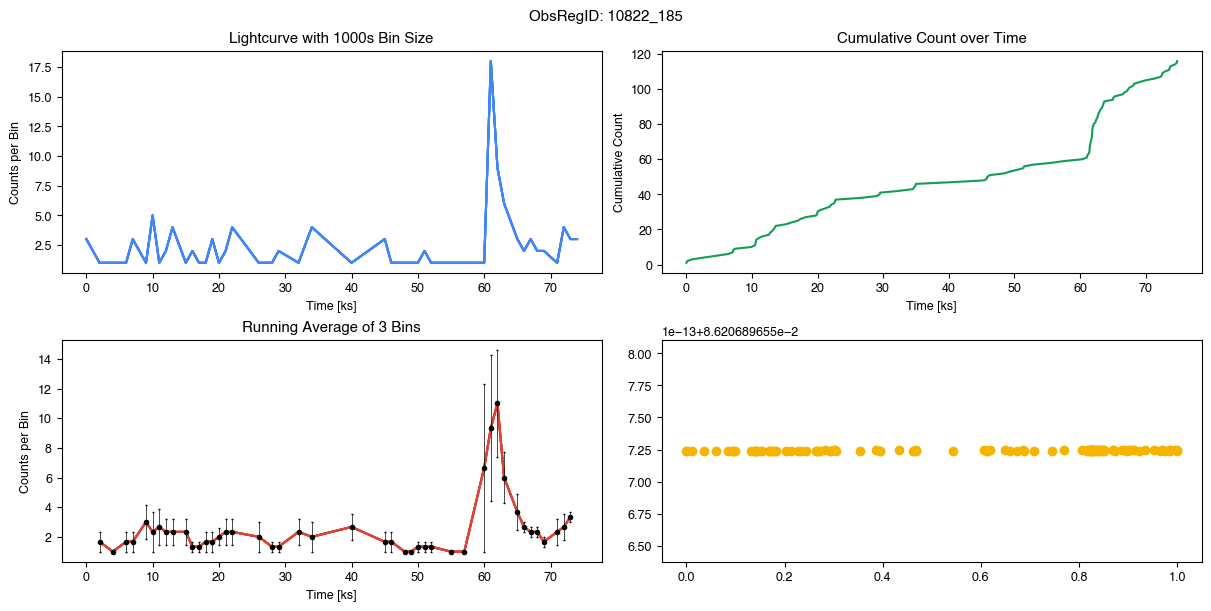

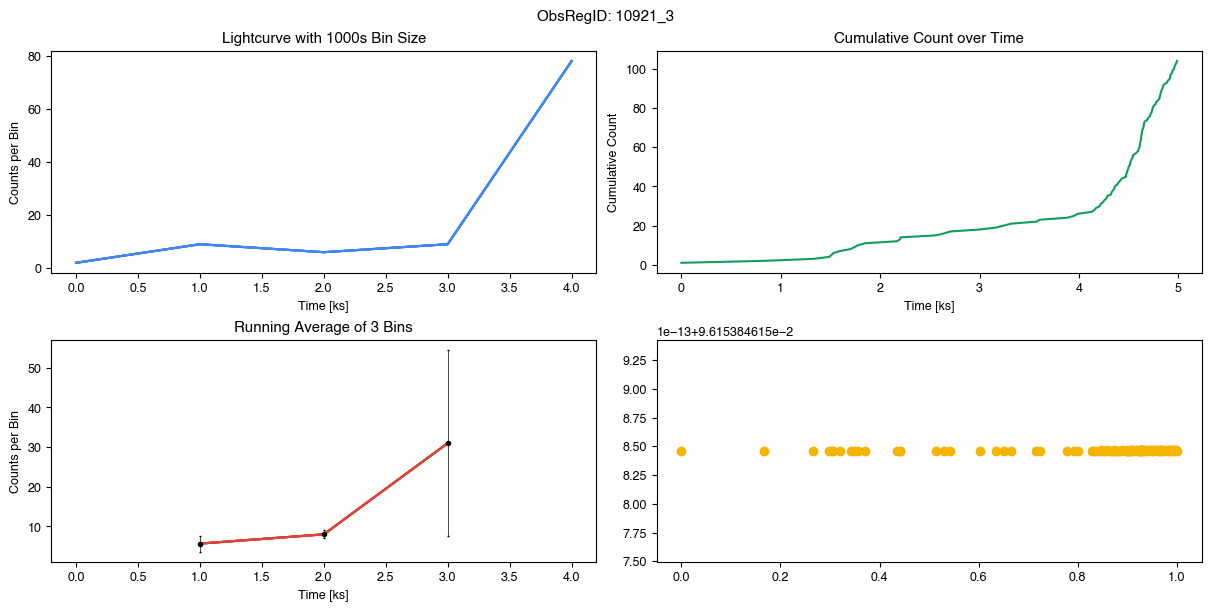

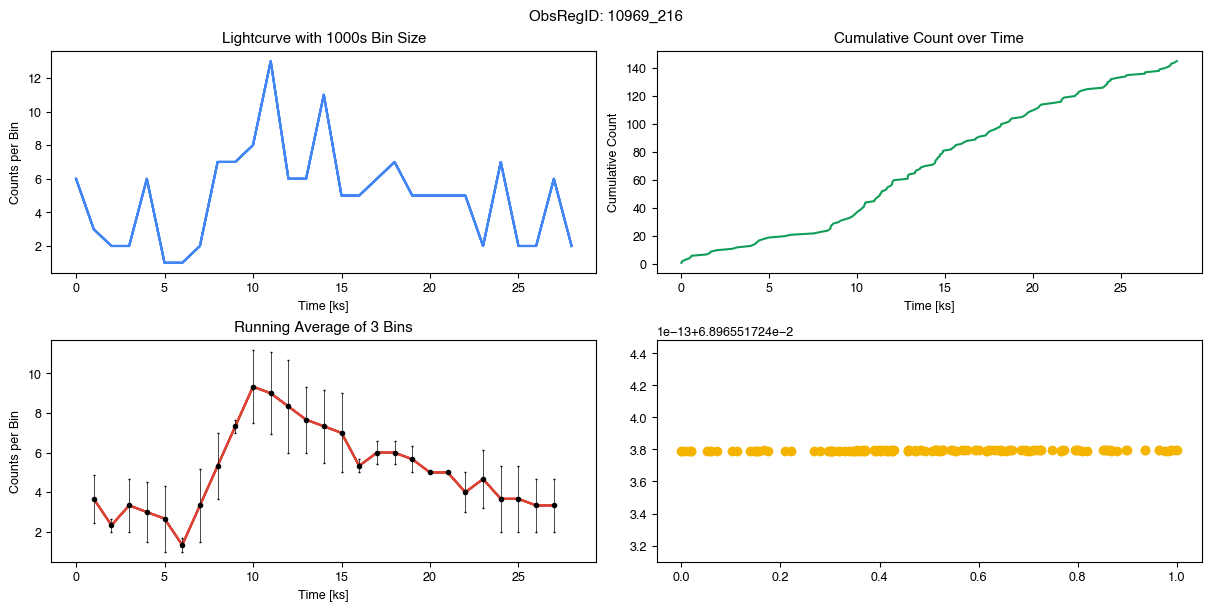

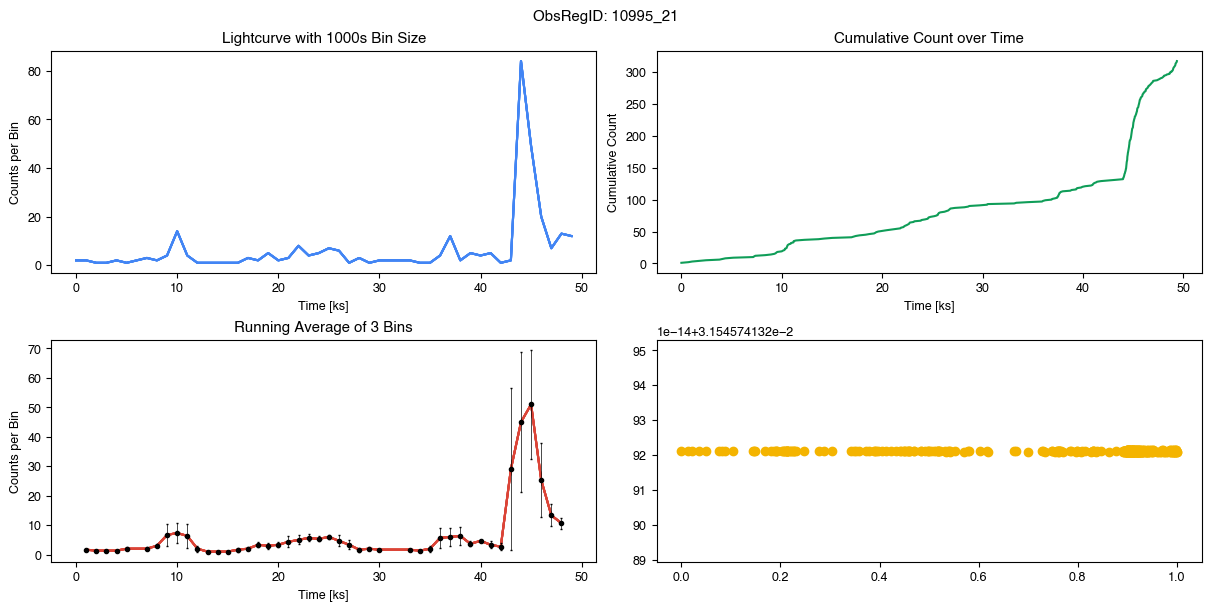

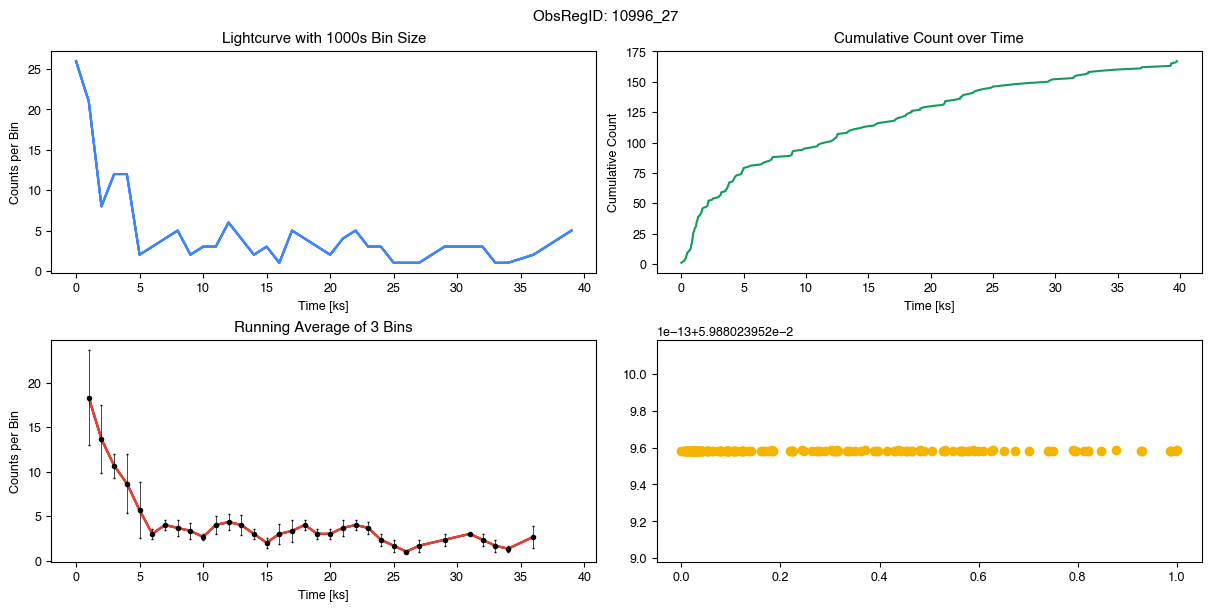

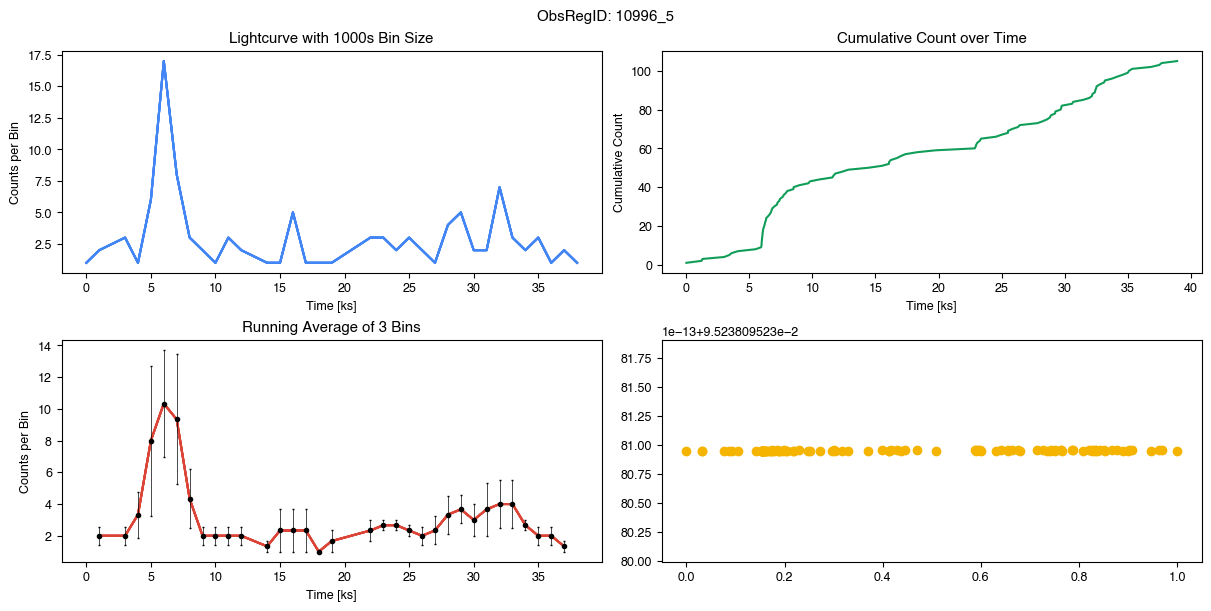

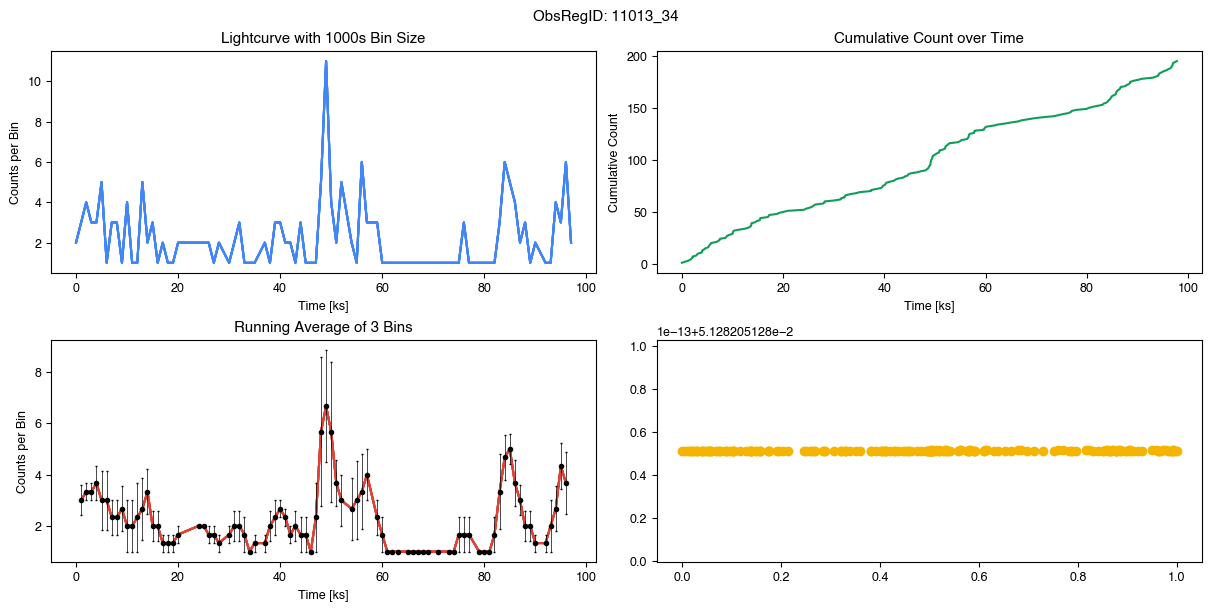

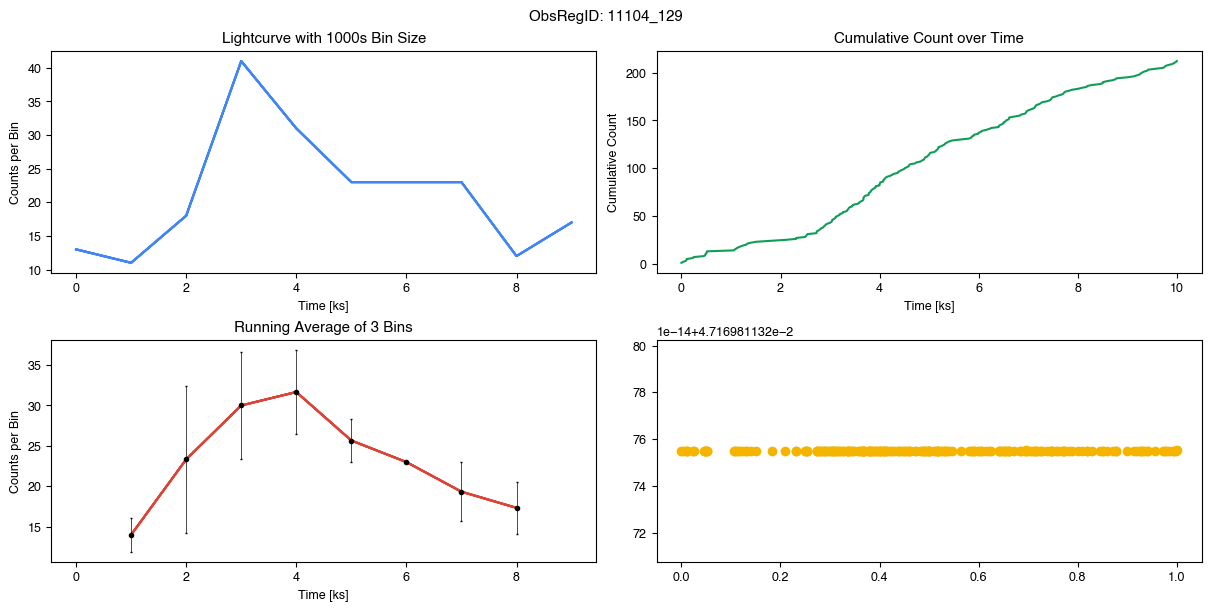

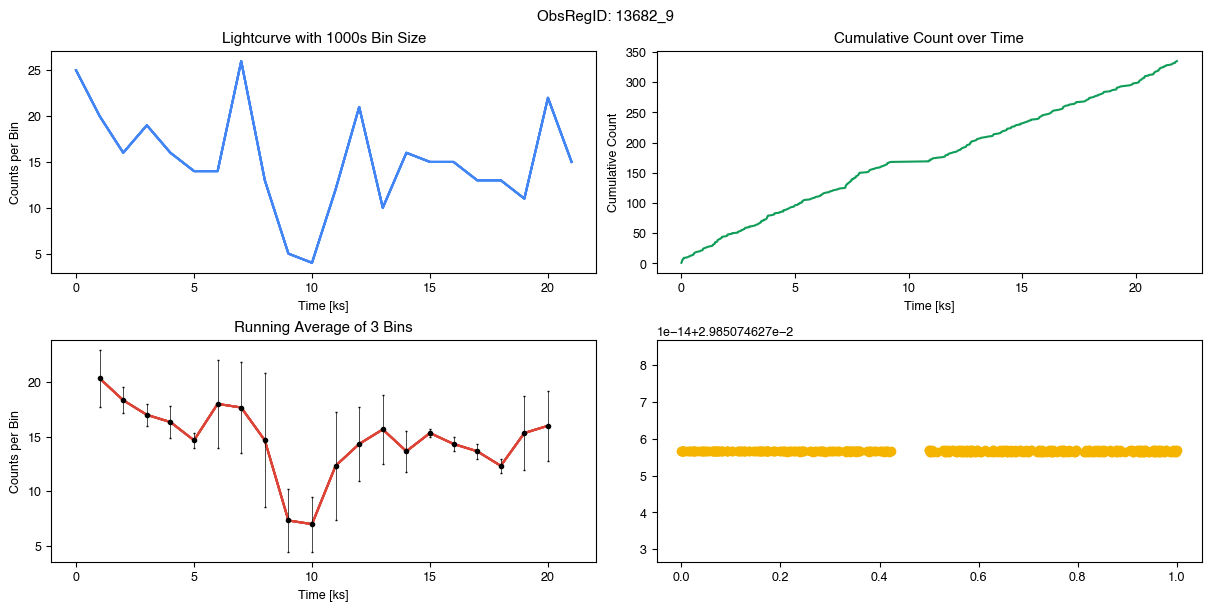

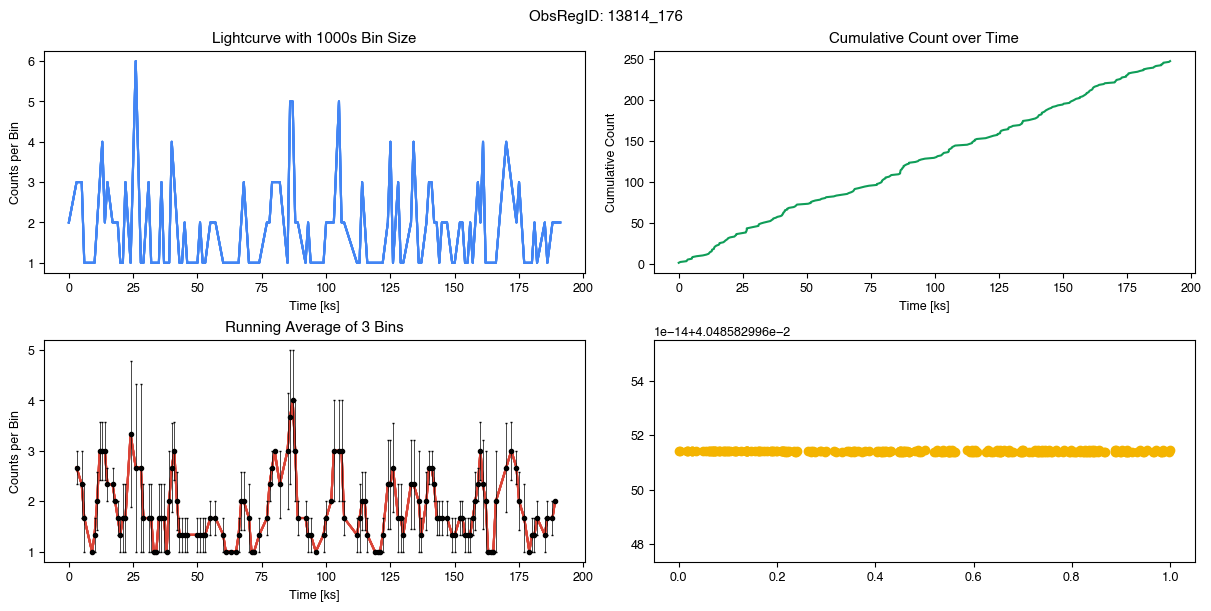

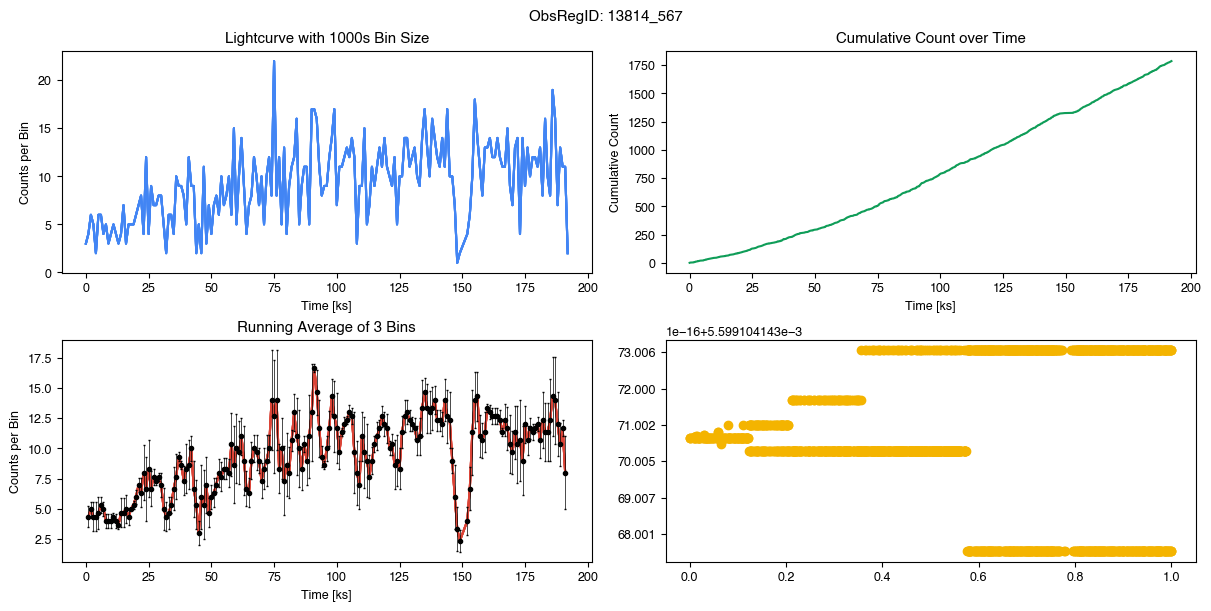

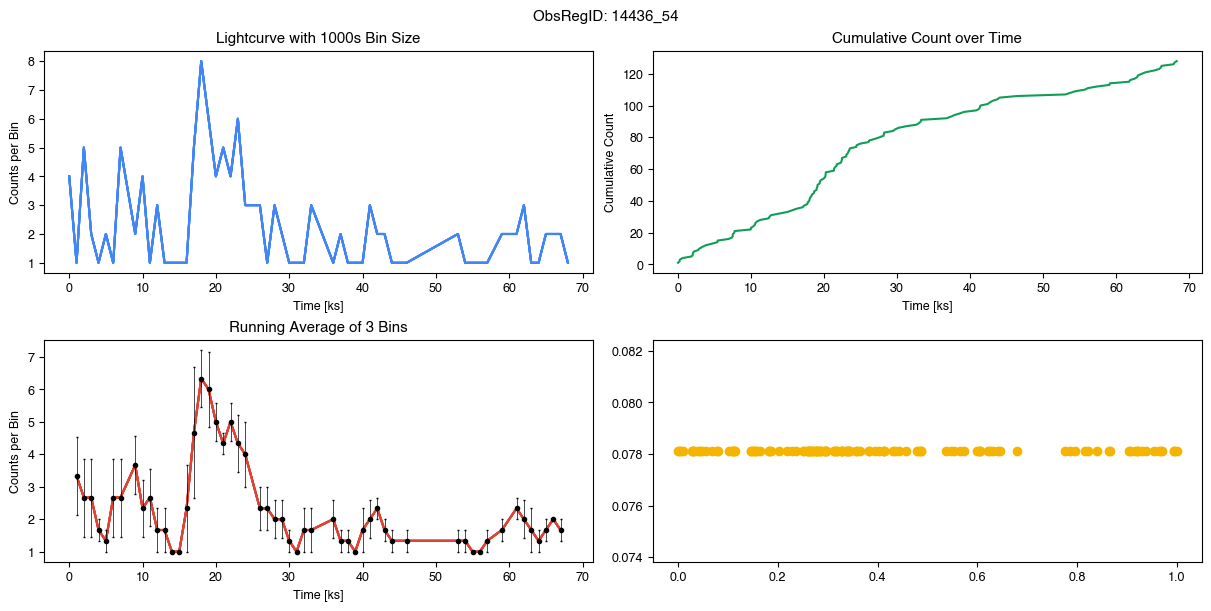

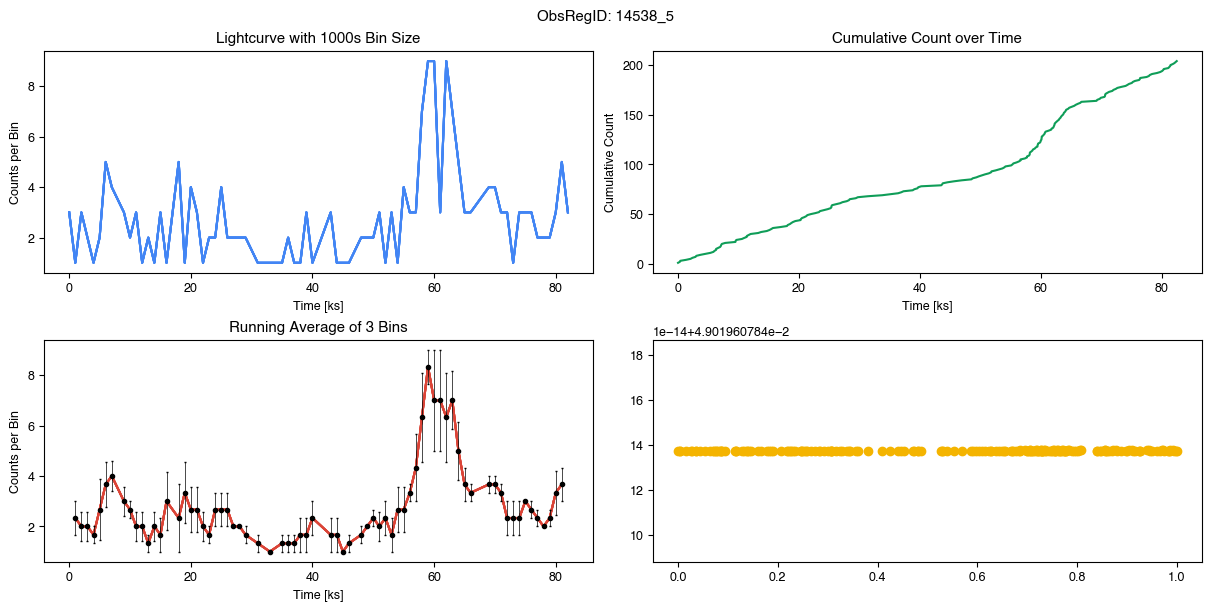

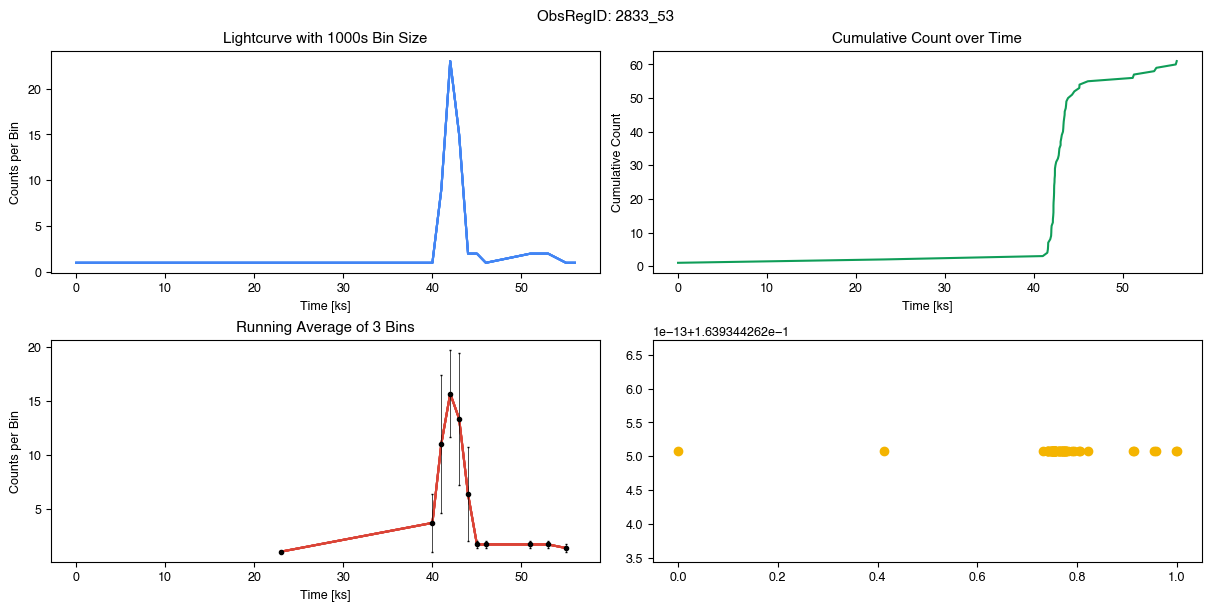

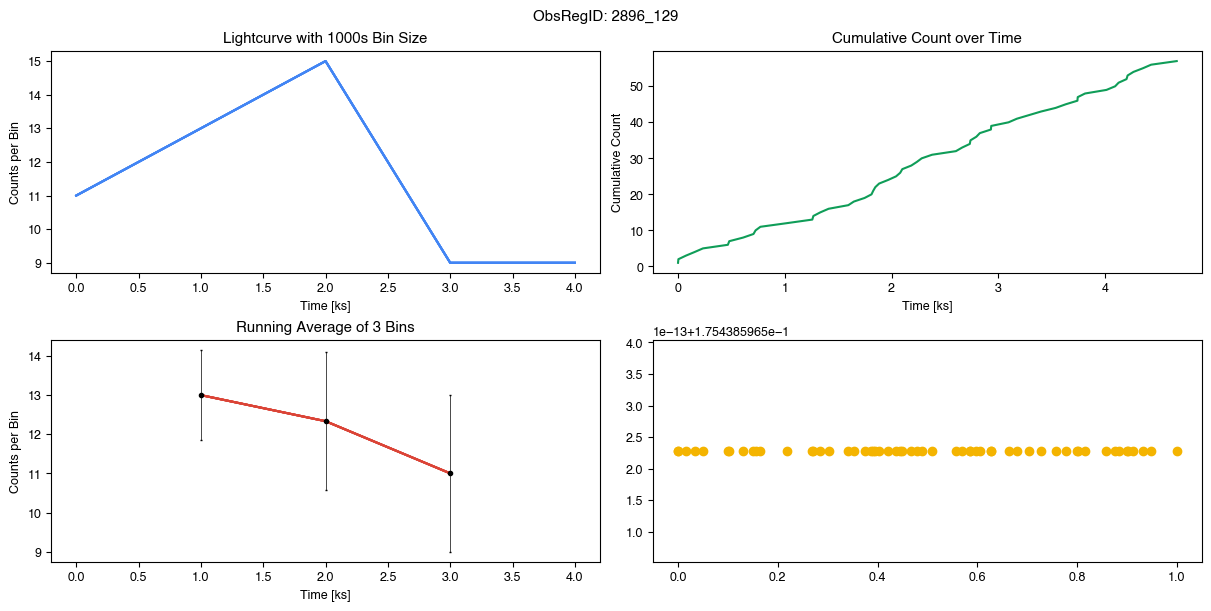

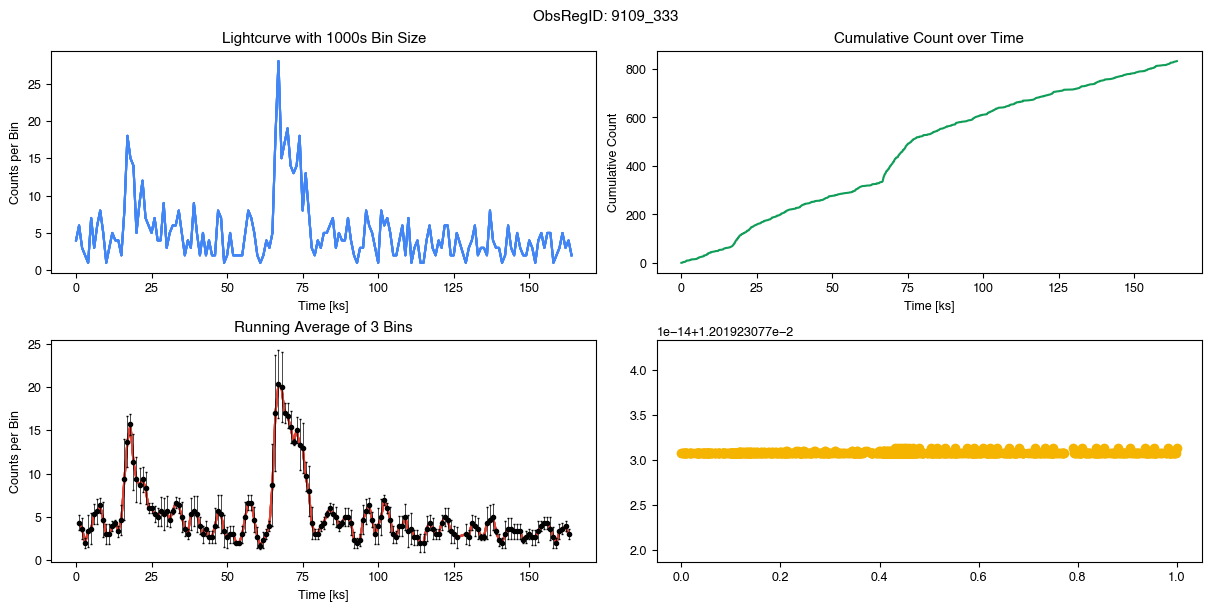

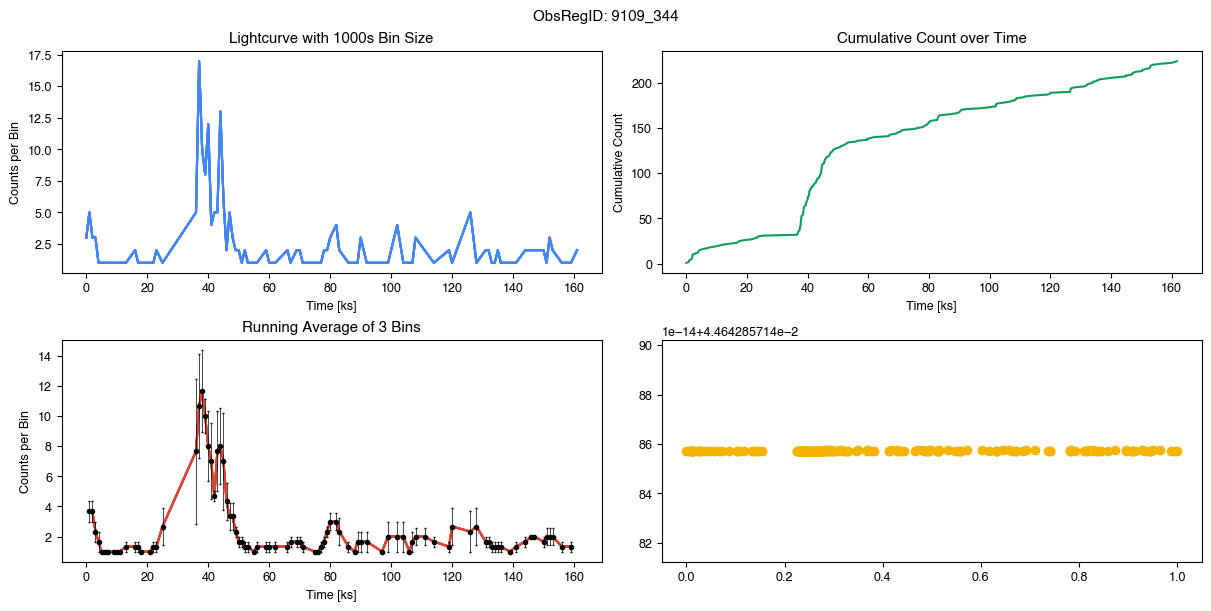

In [9]:
# Loop over all eventfiles
for id_name, dfi in df_eventfiles_group:
    # Define Colour Scheme
    google_blue = '#4285F4'
    google_red = '#DB4437'
    google_yellow = '#F4B400'
    google_green = '#0F9D58'
    # Define Font Settings
    plt.rcParams.update({'font.size': 9})
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['font.family'] = 'sans-serif'
    # Create subplots 
    fig, axs = plt.subplots(2, 2, figsize=(12, 6),constrained_layout = True)
    fig.suptitle(f'ObsRegID: {id_name}',fontweight="bold")
    # Create binned lightcurve
    df = dfi.copy()
    df['time'] = dfi['time'] - min(dfi['time'])
    df_binned = df.groupby(df['time'] // 1000 * 1000).count()
    # Plot binned lightcurve
    axs[0,0].plot(df_binned.index/1000, df_binned, color = google_blue)
    axs[0,0].set_xlabel('Time [ks]')
    axs[0,0].set_ylabel('Counts per Bin')
    axs[0,0].set_title(f'Lightcurve with 1000s Bin Size')
    # Create rolling 3-bin averaged lightcurved
    df_rolling = df_binned.rolling(window=3, center=True).mean()
    rolling_std = df_binned.rolling(window=3, center=True).std()
    errors = rolling_std['time']/math.sqrt(3)
    # Plot rolling 3-bin averaged lightcurved
    axs[1,0].plot(df_rolling.index/1000, df_rolling, color = google_red)
    axs[1,0].errorbar(df_rolling.index/1000, df_rolling['time'], yerr = errors, xerr = None,fmt ='.',color = "black",linewidth = .5,capsize = 1)
    axs[1,0].set_xlabel('Time [ks]')
    axs[1,0].set_ylabel('Counts per Bin')
    axs[1,0].set_title('Running Average of 3 Bins')
    # Create cumulative count plot
    df_cumulative = df.copy()
    df_cumulative['count'] = 1
    df_cumulative['cumulative_count'] = df_cumulative['count'].cumsum()
    # Plot cumulative count plot
    axs[0,1].plot(df_cumulative['time']/1000, df_cumulative['cumulative_count'],color = google_green)
    axs[0,1].set_xlabel('Time [ks]')
    axs[0,1].set_ylabel('Cumulative Count')
    axs[0,1].set_title('Cumulative Count over Time')
    # Create normalized cumulative count plot
    max_time = df_cumulative['time'].max()
    min_time = df_cumulative['time'].min()
    max_count = df_cumulative['cumulative_count'].max()
    min_count = df_cumulative['cumulative_count'].min()
    df_cumulative['time_norm'] = df_cumulative['time']/max_time
    df_cumulative['cumulative_count_norm'] = df_cumulative['cumulative_count']/max_count
    df_cumulative['gradient'] = np.gradient(df_cumulative['cumulative_count'], df_cumulative['time'])
    df_cumulative['gradient_norm'] = np.gradient(df_cumulative['cumulative_count_norm'],0.1)
    df_cumu_bin = df_cumulative.copy()
    # df_cumu_bin = df_cumulative.groupby(df_cumulative['time_norm'] // 1000 * 1000).mean()
    # axs[1,1].scatter(df_cumu_bin.index/1000, df_cumu_bin['gradient_norm'], color = google_yellow)
    axs[1,1].scatter(df_cumulative['time_norm'], df_cumulative['gradient_norm'], color = google_yellow)
    # axs[1,1].plot(df_cumulative['time_norm'], df_cumulative['cumulative_count_norm'],color = google_green)


    

    # axs[1,1].plot(df_cumulative['time_norm'], df_cumulative['gradient'])
    # axs[1,1].set_xlabel('Time')
    # axs[1,1].set_ylabel('Gradient')

    # Plot normalized cumulative count plot
    # parx = axs[0,1].twiny()
    # pary = axs[0,1].twinx()
    # axs[0,1].set_xlim(min_time/1000, max_time/1000)
    # axs[0,1].set_ylim(min_count, max_count)
    # parx.set_xlim(0, 1)
    # pary.set_ylim(0, 1)

    # Show the plot
    plt.show()

  

In [ ]:
# This is a function that creates some plots of lightcurves! Basically you give it the coords and obsid that you want to look at, and it will produce a cumulative lightcurve, a binned lightcurve, and a running average.
# The argument 

def lc_plot_fun(df_grouped_eventfile, id_name, avg_plot = True, save_png = False):
  """
  DESCRIPTION: Reduces evenfiles table and properties table to required columns and adds unique ID, can now be used for data representation function
  INPUT: 1. Original eventfile table, 2. Original properties table, 3. Global Path, 4. Set Name
  OUTPUT: 1. Reduced eventfile table, 2. Reduced properties table
  """
  # downloads lightcurve and reads important info into a list
  info = pd.read_table(f"./textfiles/{textfile}", " ")
  # info.columns =['TIME_BIN', 'TIME_MIN', 'TIME', 'TIME_MAX',"COUNTS", "STAT_ERR", "AREA", "EXPOSURE", "COUNT_RATE", "COUNT_RATE_ERR"]
  # print(info.shape[0])
  #reset times and drop unecessary columns
  times = df_grouped_eventfile["time"].tolist()
  initial_time = times[0]
  times = [i - initial_time for i in times]
  # list of bins, containing the number of photons in each one
  binned_list = []
  starting_time = 0
  #keeps track of how many photons are in current bin so far
  tally = 0
  current_bin = 0
  for i,row in enumerate(info["COUNTS"]):
    # adds this row's number of photons to the tally
    tally += row
    # checks how many seconds corresponds to this row
    seconds = i*3.24104
    # determines what bin number this should be in then.
    bin_num = int(seconds/(binsize))
    if bin_num - current_bin == 1:
      # if we have just entered a new bin, it adds all the photons received in the previous bin to thatbin
      binned_list.append(tally)
      # resets the tally and moves up one bin
      tally = 0
      current_bin += 1

  number_ahead_and_behind = 1
  # Running Averages
  if avg_True == True:
    avgs = []
    errors = []
    for i in range(0,len(binned_list)):
      # if i < 2:
      #   sum = binned_list[i]+binned_list[i+1]+binned_list[i+2]
      #   avg = sum /3
      #   avgs.append(avg)
      if i >= number_ahead_and_behind and i <= len(binned_list)-number_ahead_and_behind-1:
        list_of_averages = []
        list_of_averages.append(binned_list[i])
        for j in range(1,number_ahead_and_behind+1):
          list_of_averages.append(binned_list[i-j])
          list_of_averages.append(binned_list[i+j])
        summed = sum(list_of_averages)
        avg = summed / (number_ahead_and_behind*2+1)
        std_dev = statistics.stdev(list_of_averages)
        error = std_dev / (math.sqrt(number_ahead_and_behind*2+1))
        errors.append(error)
        avgs.append(avg)
      # if i > len(binned_list)-3:
      #   sum = binned_list[i]+binned_list[i-1]+binned_list[i-2]
      #   avg = sum /3
      #   avgs.append(avg)
      
    # print(avgs)

  # creates a times list for the x-axis in kiloseconds
  bin_times = np.arange(0,times[-1],binsize)
  bin_times = bin_times/1000

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
  plt.rcParams["figure.figsize"] = (15,10)

  # times = [i+ 10000 for i in times]
  # bin_times = [i+ 10 for i in bin_times]

  # creates the graph with appropriate labels
  ax2.step(bin_times[1:], binned_list)
  ax2.set_xlabel("Time [kiloseconds]",fontsize=15)
  ax2.set_title(f"LightCurve with {binsize}s Bin Size",fontsize=15)
  ax2.set_ylabel("Photon Count per Bin",fontsize=15)
  ax2.tick_params(axis='both', which='major', labelsize=20)
  ax2.tick_params(axis='both', which='minor', labelsize=8)
  # ax2.axvline(x = line1, color = 'r', linewidth =.8, linestyle = "dashed")
  # ax2.axvline(x = line2, color = 'r', linewidth =.8, linestyle = "dashed", label = f'Beginning -- {line2}ks')
  # ax2.text(line1 - 2.2,0,line1,rotation=0)
  # ax2.text(line2+ .2 ,0,line2,rotation=0)
  # if avg == True:

  ax3.set_xlabel("Time [kiloseconds]",fontsize=15)
  ax3.set_title(f"Running Average of {number_ahead_and_behind*2+1} bins",fontsize=15)
  ax3.set_ylabel("Photon Count per Bin",fontsize=15)
  ax3.tick_params(axis='both', which='major', labelsize=20)
  ax3.tick_params(axis='both', which='minor', labelsize=8)
  ax3.plot(bin_times[number_ahead_and_behind:len(bin_times)-number_ahead_and_behind-1],avgs, color = "crimson",linewidth=2.5)
  ax3.errorbar(bin_times[number_ahead_and_behind:len(bin_times)-number_ahead_and_behind-1], avgs,
             yerr = errors,
             xerr = None,
             fmt ='.',
             color = "black",
             linewidth = .5,
             capsize = 1)


  # this creates the cumulative graph
  cumu_counts = []
  tot_counts = 0
  for row in info["COUNTS"]:
    tot_counts += row
    cumu_counts.append(tot_counts)



  # plots it
  kilo_times = [i/1000 for i in times]
  ax1.plot(kilo_times, cumu_counts)
  ax1.set_xlabel('Time [kiloseconds]', fontsize=15)
  ax1.set_ylabel('Cumalative Photon Count', fontsize=15)
  ax1.set_title(f"Cumulative Photon Count vs Time", fontsize=15)
  ax1.tick_params(axis='both', which='major', labelsize=20)
  ax1.tick_params(axis='both', which='minor', labelsize=8)


  # makes a filename for easier organization
  parts =textfile.split("_")
  plt.suptitle(f"{parts[0]} ObsID {parts[1]}",fontsize=15)
  plt.figtext(0.5, 0.01, f"Initial Time: {initial_time}", wrap=True, horizontalalignment='center', fontsize=12)
  # print(initial_time)
  # makes easier to read and then saves file
  plt.subplots_adjust(hspace=0.5)
  if save == True:
    plt.savefig(f"{parts[0]}_ObsId_{parts[1]}.png")
    files.download(f"{parts[0]}_ObsId_{parts[1]}.png")